In [14]:
import os
import re
import csv
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from iso639 import languages
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import scipy

import time
import requests
from wayback import WaybackClient, WaybackSession

# Set notebook mode to work in offline
pyo.init_notebook_mode()

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tldextract import extract
import matplotlib.cm as cm
  
import urllib.request as urlopen
from textwrap import wrap

In [15]:
def get_error(filter_num, raw_num):
    pos_list = [1] * filter_num
    neg_list = [0] * (raw_num - filter_num)
    err = np.std(pos_list + neg_list)
    return err / np.sqrt(raw_num)

In [16]:
e = get_error(5, 400000)
low = 5 / 400000 - 0.95 * e
high = 5 / 400000 + 0.95 * e
low * 12800000000, high * 12800000000

(92023.95833824974, 227976.04166175026)

# Load metadata

In [17]:
data_dir = '/data/datacomp/'
scale_dir = os.path.join(data_dir, 'small')
metadata_dir = os.path.join(scale_dir, 'metadata')
sample_image_dir = 'sample_images'

In [18]:
df = None
for filename in os.listdir(metadata_dir):
    filepath = os.path.join(metadata_dir, filename)
    file_df = pd.read_parquet(filepath, engine='pyarrow')
    if df is None:
        df = file_df
    else:
        df = pd.concat([df, file_df], ignore_index=True)

In [19]:
from urllib.parse import urlparse

def get_base_url(url):
    extract_url = extract(url)
    base = extract_url.domain
    suffix = extract_url.suffix
    return base + '.' + suffix

df['base_url'] = df['url'].apply(get_base_url)
df

uid  \
0         68ba78085ddc76780dfbceec1e5d42ac   
1         1f7b134d137b77f043c2d984c819d099   
2         2a2bb8d1fc6e43d272c009d825d8a423   
3         0c4af8720b06e5e30fd14c9333c69163   
4         48bc9d12f9fdbfb7cad8816627a16eb4   
...                                    ...   
12799995  c40d0839d1ef3141925b46e00f4ea974   
12799996  e471e9f3dfc8059c667bf6337f9d190d   
12799997  95db0725c41c82fe1f494f9b6aec8e8a   
12799998  3bc76f4ab48059f5e4af59358c1840f6   
12799999  8912c21988a83bbdc856e4149a4a4710   

                                                        url  \
0         https://photos.smugmug.com/Desert-100/2017-Des...   
1         http://173.214.250.35/76ZwuWvsbgwP082uQJ2VnncH...   
2         https://a.wattpad.com/useravatar/thisisastandu...   
3         https://static.wixstatic.com/media/9f980f_e34c...   
4         https://img1.etsystatic.com/027/0/6615545/il_3...   
...                                                     ...   
12799995  https://javaearthcoffee.com/wp-content/uploads...   
12799996  https://files.oldi.ru/export/0000000038/046898...   
12799997  https://www.masterfoto.lv/209763-home_default/...   
12799998  http://t1.ftcdn.net/jpg/00/49/95/76/110_F_4995...   
12799999  http://assets.cookeatshare.com/assets/recipe-a...   

                                                       text  original_width  \
0                                                  IMG_1788             300   
1                                     Diana frank le klloun             320   
2                                          thisisastandup69             128   
3                                               lidar 2.JPG             286   
4         1 Yd 3/4&quot; Wide Gorgeous Vintage Victorian...             340   
...                                                     ...             ...   
12799995                                                bg1             300   
12799996      Телефон IP Cisco SPA502G-XU xu rui clustering             800   
12799997  Vairs neražo - Colorama background 1.35x11, se...             250   
12799998                 Solaranlage, Strom, Umwelt, Himmel             110   
12799999                                  Russian Tea Cakes              85   

          original_height  clip_b32_similarity_score  \
0                     450                   0.216797   
1                     240                   0.235962   
2                     128                   0.134521   
3                     190                   0.219849   
4                     270                   0.342285   
...                   ...                        ...   
12799995              300                   0.193604   
12799996              800                   0.279053   
12799997              250                   0.303467   
12799998               73                   0.275879   
12799999               85                   0.190430   

          clip_l14_similarity_score  \
0                          0.201050   
1                          0.123596   
2                          0.151978   
3                          0.258301   
4                          0.301025   
...                             ...   
12799995                   0.185547   
12799996                   0.260742   
12799997                   0.271484   
12799998                   0.193848   
12799999                   0.088806   

                                                face_bboxes  \
0         [[0.4974687993526459, 0.1723930984735489, 0.60...   
1         [[0.29118314385414124, 0.08071886003017426, 0....   
2         [[0.2151436060667038, 0.33176833391189575, 0.6...   
3         [[0.7299515604972839, 0.14564916491508484, 0.7...   
4         [[0.3746822476387024, 0.005450154189020395, 0....   
...                                                     ...   
12799995                                                 []   
12799996                                                 []   
12799997                                                 []   
12799998

In [20]:
l14_scores = df['clip_l14_similarity_score'].tolist()
min_threshold = np.percentile(l14_scores, 70)
print(min_threshold)
filtered_df = df[df['clip_l14_similarity_score'] > min_threshold]
excluded_df = df[df['clip_l14_similarity_score'] <= min_threshold]

assert(len(filtered_df) + len(excluded_df) == len(df))
print(len(df), len(filtered_df)) # 12.8M --> 3.94M filtered
print(len(filtered_df) / len(df)) # 30%

0.24267578125
12800000 3839815
0.299985546875


In [21]:
df['is_kept'] = df['clip_l14_similarity_score'].apply(lambda x: x > min_threshold)

In [22]:
raw_captions = df['text'].tolist()
filtered_captions = filtered_df['text'].tolist()
excluded_captions = excluded_df['text'].tolist()

## Medium scale (crashes D:)

In [ ]:
# medium_scale_dir = os.path.join(data_dir, 'medium')
# medium_metadata_dir = os.path.join(medium_scale_dir, 'metadata')

# medium_df = None
# for filename in os.listdir(medium_metadata_dir):
#     filepath = os.path.join(medium_metadata_dir, filename)
#     file_df = pd.read_parquet(filepath, engine='pyarrow')
#     if medium_df is None:
#         medium_df = file_df
#     else:
#         medium_df = pd.concat([medium_df, file_df], ignore_index=True)

# medium_df['base_url'] = medium_df['url'].apply(get_base_url)
# medium_df

In [ ]:
# medium_l14_scores = df['clip_l14_similarity_score'].tolist()
# min_threshold = np.percentile(l14_scores, 70)
# print(min_threshold)
# filtered_df = df[df['clip_l14_similarity_score'] > min_threshold]
# excluded_df = df[df['clip_l14_similarity_score'] <= min_threshold]

# assert(len(filtered_df) + len(excluded_df) == len(df))
# print(len(df), len(filtered_df)) # 12.8M --> 3.94M filtered
# print(len(filtered_df) / len(df)) # 30%

# Utterance date (base_url)

In [9]:
client = WaybackClient()
results = client.search('nasa.gov')
record = next(results)
record.timestamp.strftime("%Y%m%d%H%M%S")

'19961231235847'

In [10]:
def peek(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first

In [ ]:
NUM_SAMPLE = 1000000
df_sample = df.sample(NUM_SAMPLE, random_state=0)

uid_to_base_url_timestamps = {}
count = 0

for i, row in df_sample.iterrows():
    uid = row['uid']
    base_url = row['base_url']
    url = row['url']

    count += 1
    if uid in uid_to_base_url_timestamps:
        continue

#     time.sleep(1)
    
    try:
        results = client.search(base_url)
        record = peek(results)
        if record and record.timestamp:
            earliest_timestamp = int(record.timestamp.strftime("%Y%m%d%H%M%S"))
            uid_to_base_url_timestamps[uid] = earliest_timestamp
        else:
            uid_to_base_url_timestamps[uid] = None
        print(count, base_url, uid_to_base_url_timestamps[uid])
    except Exception as e:
        print('ERROR', e, count, base_url)

1 rightinthebox.com 20070620172226
2 hindustantimes.com 19970328124455
3 gstatic.com 20080714031855
4 canstockphoto.com 20040407213420
5 specsserver.com 20090612231839
6 livestream.com 19961219045330
7 les-goodies.fr 20180708054921
8 pinimg.com 20080311233256
9 specsserver.com 20090612231839
10 wixstatic.com 20130712011547
11 deviantart.net 20010223192857
12 sabr.cc 20101129195038
13 royalfincas.com 20180603145819
14 fc2.com 20000621103337
15 conrad.com 20000510022852
16 22slides.com 20110429202013
17 jiwu.com 20040523180642
18 miradocumentales.com 20130405074459
19 wordpress.com 20040723044112
20 di-static.com None
21 decor-plus.com.ua 20130506055752
22 hugkumi-life.jp 20190726120716
23 zenit.ba 20120906042158
24 yiban.io 20170523022551
25 plurielles.fr 20001110153300
26 ebaystatic.com 20130711091457
27 ssl-images-amazon.com 20130711082144
28 dhz-proshop.be 20150121163937
29 squarespace-cdn.com None
30 sportngin.com 20090905145103
31 google.com.na 20040320233500
32 staticflickr.com 20

256 mu-mo.net 20050623013332
257 storehippo.com 20101220100457
258 abra-meble.pl 20030414190450
259 amazonaws.com 20060616182622
260 cloudfront.net 20130711043259
261 vteximg.com.br 20140707111234
262 tripadvisor.com 20000821062203
263 newsmarket.com.ua 20100713011313
264 euronics.ee 20031021041349
265 pimg.tw 20090906112720
266 brzozowiana.pl 20120509041139
267 prom.st 20180129234038
268 images-amazon.com 20130711005733
269 esc-grossiste.fr 20081106111713
270 gravatar.com 20040806063713
271 media-amazon.com None
272 scribdassets.com 20090922221206
273 wp.com 19961022180147
274 ssl-images-amazon.com 20130711082144
275 yimg.jp 20130711154057
276 shopify.com 20051109032954
277 pet-kazoku.net 20130310002517
278 dreamstime.com 20010223203352
279 fishcq.cn 20200930100705
280 bgxcdn.com 20200207011027
281 ngfiles.com 20071013044559
282 contactmusic.com 20000407185852
283 bauhaus.se 20020605040151
284 puppo.ru 20090211100145
285 okorder.com 20080820082614
286 gnavi.co.jp 20010206204857
287 40

508 pinimg.com 20080311233256
509 wixstatic.com 20130712011547
510 dhstatics.com 20130601202445
511 offers.gallery 20160330161812
512 istockphoto.com 20000407101943
513 artflakes.com 20100508142403
514 auto-che.com 20100424044220
515 alicdn.com 20090209043047
516 123rf.com 20050508204015
517 odr.net.pl 19990125101752
518 pinimg.com 20080311233256
519 mariannetaylorphotography.co.uk 20081023043643
520 cmgirls.com 20040322093627
521 ypcdn.com 20130713060752
522 shortpixel.ai 20181025171829
523 devis-alarme-incendie.com 20180703040034
524 wp.com 19961022180147
525 safarme.com 20160223105026
526 verwaltungsportal.de 20070616024353
527 expertagent.co.uk 20040909143926
528 seesaa.net 20031208073621
529 globetrotter.de 19961105102519
530 fbcd.co 20181227053144
531 cloudinary.com 20110722195615
532 gravatar.com 20040806063713
533 blogspot.com 20001018094021
534 ebayimg.com 20130711035120
535 gravatar.com 20040806063713
536 societe-philanthropique.fr 20151118045253
537 onlineguru.ru 20070915100

756 fc2.com 20000621103337
757 ciespcampinas.org.br 20110315063345
758 images-amazon.com 20130711005733
759 neo-himeism.net 20040528082622
760 widencdn.net 20101226222929
761 cloudfront.net 20130711043259
762 adsoxa.com 20150801041237
763 wheels.ca 19961223200023
764 chinawutong.com 20080704190228
765 starfunken.com 20090816105314
766 aliyuncs.com 20130816115631
767 sdamustang.com 20110111094658
768 gothamgal.com 20040411013851
769 cloudfront.net 20130711043259
770 thespringgrass.com 20210311165535
771 wp.com 19961022180147
772 yimg.com 20070428055017
773 farmaciacampolivar.es 20171008152853
774 now.com 19961112121854
775 bonami.sk 20130130043036
776 tmpo.co 20170823085054
777 ucf.edu 19961228043452
778 woonprettig.nl 20160424171920
779 ggpht.com 20080414003001
780 proppy.app None
781 essgete.com 20110201140155
782 avvo.com 20011120131840
783 digikala.com 20070223050847
784 anninhthudo.vn 20070510142530
785 exblog.jp 20040213015648
786 jagek.com 20020609114258
787 ebayimg.com 201307110

1008 speakingtree.in 20100303213224
1009 minutemediacdn.com 20160805213619
1010 newsserve.net 20100330075639
1011 fnp.com 20001020160138
1012 donebymyself.nl 20140517081717
1013 dlahandlu.pl 20090225184951
1014 stockfresh.com 20100327084426
1015 cdnme.se 20130302045347
1016 exblog.jp 20040213015648
1017 akamaized.net None
1018 milanuncios.com 20040326115031
1019 elcontainer.cl 20160427100046
1020 citysearch.net 20130717233257
1021 40listings.com 20100713105302
1022 wallapop.com 20130911094223
1023 imgsinemalar.com 20100526124641
1024 apklade.com 20201022174142
1025 travelminit.com 20130815084956
1026 denik.cz 20000610225430
1027 mehrnews.com 20030623233704
1028 amazonaws.com 20060616182622
1029 wixstatic.com 20130712011547
1030 cyclingsouvenirs.com 20120710113546
1031 amazonaws.com 20060616182622
1032 rackcdn.com 20130711034620
1033 gravatar.com 20040806063713
1034 slpdiggers.com 20080511172745
1035 mzres.com 20180804231136
1036 yimg.com 20070428055017
1037 fc2.com 20000621103337
1038 

1253 habcdn.com None
1254 krutomer.ru 20050730002744
1255 allosurf.net 20041109114448
1256 wordpress.com 20040723044112
1257 brandear.jp 20080502050445
1258 wp.com 19961022180147
1259 pcmount.by 20031212101711
1260 ssl-images-amazon.com 20130711082144
1261 bmon.co.uk 20080201133230
1262 kfzimg.com 20140901144839
1263 ebaystatic.com 20130711091457
1264 xypt.top None
1265 qipeiren.com 20051102000828
1266 smugmug.com 20021001210841
1267 nocookie.net 20030906144437
1268 datpiff.com 20051125145814
1269 wp.com 19961022180147
1270 svetmazlika.cz 20171120154734
1271 ebayimg.com 20130711035120
1272 waguankuaican.com 20100530063645
1273 mapecology.ma 20161110070942
1274 radiogold.pro 20210925215340
1275 pinimg.com 20080311233256
1276 cloudfront.net 20130711043259
1277 sidabrina.lt 20090612012429
1278 dreamstime.com 20010223203352
1279 specsserver.com 20090612231839
1280 decine21.com 20061030014319
1281 gravatar.com 20040806063713
1282 flickr.com 20040226214842
1283 ebaystatic.com 20130711091457


1498 wordpress.com 20040723044112
1499 muscache.com 20111007044534
1500 hotellook.com 20010404055930
1501 8tracks.com 20041202095243
1502 edugorilla.com 20160919001505
1503 msecnd.net 20130711042047
1504 benjstone.com 20120121102555
1505 canstockphoto.com 20040407213420
1506 specsserver.com 20090612231839
1507 alicdn.com 20090209043047
1508 gosiertourisme.fr 20170109203633
1509 stockfresh.com 20100327084426
1510 googleapis.com 20080414173006
1511 harfetaze.com 20100613031935
1512 yahoo.com 19961017235908
1513 maudgal-int.com 20141115192748
1514 ekladata.com 20121228054807
1515 mlspin.com 19991127151223
1516 wp.com 19961022180147
1517 scoop.it 20000304072148
1518 depositphotos.com 20090329055111
1519 12349.net 20051026145300
1520 mlstatic.com 20091225135304
1521 fastly.net 20130713005344
1522 guim.co.uk 20130711085833
1523 bauersecure.com 20130712182010
1524 vestitambov.ru 20090607081024
1525 awsli.com.br 20151125225842
1526 wixstatic.com 20130712011547
1527 wp.com 19961022180147
1528 s

1743 hotel-stangl.de 20001110141700
1744 ebayimg.com 20130711035120
1745 portalcreditos.es 20200630004502
1746 shannonsklossweddings.com 20160204224443
1747 tripadvisor.com 20000821062203
1748 ebayimg.com 20130711035120
1749 vsemmorpg.ru 20100816151602
1750 wixstatic.com 20130712011547
1751 smugmug.com 20021001210841
1752 wordpress.com 20040723044112
1753 amazonaws.com 20060616182622
1754 kb-cdn.com None
1755 delcampe-static.net 20101005063436
1756 cars-kids.com 20130717200114
1757 constantinnautics.md 20190116225113
1758 adorewe.com 20161010132839
1759 fastly.net 20130713005344
1760 media-amazon.com None
1761 radiocut.site 20190625091549
1762 alicdn.com 20090209043047
1763 fastly.net 20130713005344
1764 st-hatena.com 20110207230708
1765 gravatar.com 20040806063713
1766 etsystatic.com 20130711103011
1767 foyles.co.uk 19981206060356
1768 shortpixel.ai 20181025171829
1769 bing.net 19981205093755
1770 lavanguardia.com 20000511094715
1771 goobike.com 20010726111127
1772 washerhouse.com 201

1990 wsimg.com 20110225201140
1991 bnn.de 19991008160146
1992 foreign-resorts.ru 20140824124020
1993 cloudfront.net 20130711043259
1994 trozosytelas.com 20130620235036
1995 pinimg.com 20080311233256
1996 msecnd.net 20130711042047
1997 irk.ru 19961222114638
1998 bizlive.vn 20131005052422
1999 duanstellamegacity.net 20190802085825
2000 kujiale.com 20131124212747
2001 521595.cn 20210724004247
2002 redbubble.net 20090717062956
2003 scribdassets.com 20090922221206
2004 wp.com 19961022180147
2005 shutterstock.com 20040109210614
2006 amazonaws.com 20060616182622
2007 javpussy.net 20200129122917
2008 amazonaws.com 20060616182622
2009 cottonbird.fr 20180201191839
2010 ssl-images-amazon.com 20130711082144
2011 exblog.jp 20040213015648
2012 steamclue.com 20211115121841
2013 amazonaws.com 20060616182622
2014 exblog.jp 20040213015648
2015 zubakabu.com 20150611041337
2016 maximummedia.ie 20130608015637
2017 isu.pub None
2018 elektro-franck.de 20010808174105
2019 eveningg.cc 20180810215359
2020 conra

2235 officine08.it 20121028174245
2236 roseinbox.com 20170516041531
2237 wapteka.pl 20010302055527
2238 wordpress.com 20040723044112
2239 qodeinteractive.com 20120128123743
2240 bigcommerce.com 20020305221222
2241 rio2manga.com 20211218103959
2242 davidspruce.co.uk 20090726042033
2243 yimg.jp 20130711154057
2244 webixytech.com 20210222155354
2245 cpcache.com 20130711223926
2246 wmxstatic.com None
2247 technikboerse.com 20010302223053
2248 pimg.tw 20090906112720
2249 where2travel.com 20000407060123
2250 statcounter.com 20001204154200
2251 kwork.ru 20100204200530
2252 dreamstime.com 20010223203352
2253 iinfo.cz 20001202230700
2254 servimg.com 20040528064545
2255 ymeng.net 20011207233206
2256 made-in-china.com 19981203014952
2257 yatego.com 20030621192744
2258 vm-images.net 20130719093938
2259 yit.co.il 20080604002327
2260 pickx.be 20200925005556
2261 cloudfront.net 20130711043259
2262 unsplash.com 20130530182125
2263 portablepetrolgenerator.com 20100111092718
2264 livreviews.com 20100514

2481 pond5.com 20060704201629
2482 goo-net.com 20000707001753
2483 cloudfront.net 20130711043259
2484 wordpress.com 20040723044112
2485 yimg.jp 20130711154057
2486 guitaraust.com.au 20080718201902
2487 teacherspayteachers.com 20060209015617
2488 delaneybbq.com 20120510162750
2489 fordikinciel.com 20071203014556
2490 locondo.jp 20101122171856
2491 yyzfw.gov.cn 20180426205201
2492 os-cdn.com 20130817170939
2493 made-in-china.com 19981203014952
2494 commentsold.com 20160616194952
2495 gstatic.com 20080714031855
2496 skyrock.net 20001018170236
2497 7img.net 20110713220824
2498 pepperfry.com 20111016041733
2499 euronews.com 20040124191302
2500 isu.pub None
2501 petsexpert.de 20180624012544
2502 shopify.com 20051109032954
2503 momomall.com.tw 20051231104602
2504 weddingwire.com 19961219152331
2505 losingravidos.com 20130613042741
2506 pinimg.com 20080311233256
2507 photophoto.cn 20061109063431
2508 123rf.com 20050508204015
2509 prom.st 20180129234038
2510 mimove.com 20100517123635
2511 etsys

2724 sector112.com 20110722120632
2725 atlasmark.ir 20200628101057
2726 amazonaws.com 20060616182622
2727 foravto.su 20081018105333
2728 sparkplatform.com 20071023062954
2729 ytimg.com 20060821184203
2730 typepad.com 20030528110643
2731 crownawards.com 20001017232851
2732 automobilesreview.com 20080420042353
2733 pinimg.com 20080311233256
2734 sm360.ca 20130508182209
2735 artistshot.com 20110128074313
2736 yimg.com 20070428055017
2737 aliyuncs.com 20130816115631
2738 cdnws.com 20130711180147
2739 mris.com 19981201080435
2740 hit-kovry.ru 20090517014410
2741 indonetwork.co.id 20001202053800
2742 designspartan.com 20040325145651
2743 fc2.com 20000621103337
2744 thestorygraph.com 20130406125259
2745 lystit.com 20080601045643
2746 digitaltoo.com 20110202200744
2747 mariaerving.com 20090706075326
2748 gstatic.com 20080714031855
2749 boutique-sport.com 20051014125119
2750 flickr.com 20040226214842
2751 carryingcase.org 20100521044612
2752 made-in-china.com 19981203014952
2753 rbc.ua 20060402

2970 technikboerse.com 20010302223053
2971 toilet.center 20190901164302
2972 ssl-images-amazon.com 20130711082144
2973 kerntrophies.com 20010519003951
2974 pigugroup.eu 20171228135945
2975 kimthy.com 20090830133231
2976 wordpress.com 20040723044112
2977 ibizresources.com 20000408232602
2978 sportpoint.pl 20090705092109
2979 polpol.pl 20090904034658
2980 indiatvnews.com 20040212022444
2981 imgsmail.ru 20130714135135
2982 motor1.com 19990125101348
2983 intertop.ua 20021206085408
2984 glossopawnings.com 20110303105837
2985 tridge.com 19981206020427
2986 fazwaz.com 20130601043731
2987 qxmic.com 20071129220314
2988 skyrock.net 20001018170236
2989 99static.com 20130812214338
2990 pinimg.com 20080311233256
2991 woohome.com 20040301024008
2992 nocookie.net 20030906144437
2993 akcdn.net None
2994 wikidot.com 20060629192157
2995 weltmann-kfzteile.de 20170721143932
2996 wordpress.com 20040723044112
2997 staticflickr.com 20070204021045
2998 scratchdigital.co.nz 20140516203632
2999 wordpress.com 20

3215 awsli.com.br 20151125225842
3216 pinimg.com 20080311233256
3217 traktorpool.at 20020813001246
3218 wpac-annecy-2016.com 20160304065913
3219 indianxtubes.com 20111206234620
3220 criptofacil.com 20180806002252
3221 xing.com 19980210084915
3222 serbianaart.com 20060105060304
3223 pixnio.com 20161008131737
3224 homes.jp 20020111035652
3225 wp.com 19961022180147
3226 wp.com 19961022180147
3227 wordpress.com 20040723044112
3228 made-in-china.com 19981203014952
3229 designplex.it 20130308063334
3230 pinimg.com 20080311233256
3231 oe24.at 20060409091948
3232 google.com 19981111184551
3233 slickcar.com 20000822025338
3234 121xia.com 20080612043646
3235 joelsartore.com 20000408183927
3236 ebaystatic.com 20130711091457
3237 yimg.com 20070428055017
3238 wixstatic.com 20130712011547
3239 cloudinary.com 20110722195615
3240 plpcsanjose.com 20100704055527
3241 scene7.com 20010220171738
3242 staticflickr.com 20070204021045
3243 bigstockphoto.com 20040805135000
3244 jeuxetjouetsenfolie.fr 201011250

3460 compraracidohialuronico.com 20200420165158
3461 cpcache.com 20130711223926
3462 jugueteskiddyland.com 20170711211515
3463 westwing.ru 20111010151712
3464 googleusercontent.com 20090227110648
3465 gravatar.com 20040806063713
3466 canstockphoto.com 20040407213420
3467 teacherspayteachers.com 20060209015617
3468 footpack.fr 20150423143137
3469 pocketgamer.biz 20080512131744
3470 wfrcdn.com 20130422141741
3471 wp.com 19961022180147
3472 auchan.fr 19980520005528
3473 cloudfront.net 20130711043259
3474 gama.ir 20141029173059
3475 directoryofliverpool.net 20090405121824
3476 mlstatic.com 20091225135304
3477 doubanio.com None
3478 hram-slava.ru 20120321003151
3479 etsystatic.com 20130711103011
3480 hitched.co.uk 19981205031244
3481 thehempshop.co.uk 20040612185455
3482 datalabforecast.com 20210226082039
3483 bgxcdn.com 20200207011027
3484 ytimg.com 20060821184203
3485 wordpress.com 20040723044112
3486 over-blog.com 20040419075049
3487 shopify.com 20051109032954
3488 aclamo.org 20060829170

3705 gitkraken.com 20150308195547
3706 goo.ne.jp 19981111191346
3707 stockmaniacs.net 20091117020728
3708 gstatic.com 20080714031855
3709 pricerunner.com 19991127183234
3710 2findlocal.com 20090101071625
3711 fc2.com 20000621103337
3712 ebayimg.com 20130711035120
3713 olay.com.tr 20000511031803
3714 muzeulmarinei.ro 20190902145407
3715 wixstatic.com 20130712011547
3716 tripadvisor.com 20000821062203
3717 melody4arab.com 20060720011538
3718 made-in-china.com 19981203014952
3719 muscache.com 20111007044534
3720 gstatic.com 20080714031855
3721 trueachievements.com 20080412094201
3722 materialesalicante.com 20130613074707
3723 mixcloud.com 20080708034323
3724 dreamstime.com 20010223203352
3725 gengcai.com 20090208150514
3726 paleoflourish.com 20180224063807
3727 muse-ray.com 20160307142228
3728 simpalsmedia.com 20140209092931
3729 thesimplehiker.com 20180811110228
3730 brille24.de 20041130173344
3731 deccanherald.com 19970530224154
3732 googleapis.com 20080414173006
3733 4sqi.net 201307151

3950 coolrom.com 20010712003213
3951 rightmove.co.uk 20000302000713
3952 ekladata.com 20121228054807
3953 journeyspet.com 20150511014245
3954 exblog.jp 20040213015648
3955 mlstatic.com 20091225135304
3956 fastly.net 20130713005344
3957 via-mobilis.com 20081003073714
3958 urbanindo.com 20111113204915
3959 made-in-china.com 19981203014952
3960 envato.com 20080805190650
3961 ebayimg.com 20130711035120
3962 wp.com 19961022180147
3963 rackcdn.com 20130711034620
3964 winudf.com 20110208182953
3965 wordpress.com 20040723044112
3966 freepik.com 20040330152951
3967 sak.olsztyn.pl 20060621103115
3968 dcine.org 20040401062153
3969 smartblogging.net 20090528084049
3970 cloudfront.net 20130711043259
3971 nocookie.net 20030906144437
3972 ssl-images-amazon.com 20130711082144
3973 webshopapp.com 20100522020311
3974 digikala.com 20070223050847
3975 blogspot.com 20001018094021
3976 vogue.mx 20101124095420
3977 huangye88.net 20150618044848
3978 over-blog-kiwi.com 20120130045552
3979 rockbladet.se 2011110

4197 camera-warehouse.com.au 20040327040527
4198 alibris-static.com 20101202040425
4199 findpatent.ru 20120603045044
4200 wp.com 19961022180147
4201 campomoronesantolcese.it 20121111202529
4202 tripadvisor.com 20000821062203
4203 nocookie.net 20030906144437
4204 q-auto.com.ua 20211019215718
4205 ebayimg.com 20130711035120
4206 wp.com 19961022180147
4207 suryakepri.com 20170828010027
4208 favi.ro 20180124105050
4209 envato.com 20080805190650
4210 gravatar.com 20040806063713
4211 18183.com 20030202061230
4212 cpcache.com 20130711223926
4213 katherine.pl 20060203154028
4214 msecnd.net 20130711042047
4215 ibsrv.net 20081009215352
4216 pampanas.es 20090826171129
4217 cloudfront.net 20130711043259
4218 goo.ne.jp 19981111191346
4219 birdwatchingdaily.com 20110215223548
4220 uvnimg.com 20110518080432
4221 av-test.org 20010201090100
4222 doxue.com 20060513044521
4223 flickr.com 20040226214842
4224 geizkragen.de 19990125095546
4225 tower.jp 20020925193409
4226 kznpr.co.za 20130517125556
ERROR ju

4439 azureedge.net 20141216221431
4440 static9.net.au None
4441 youtube.com 20050428014715
4442 ebayimg.com 20130711035120
4443 good-designstore.com 20150315220552
4444 pracewysokosciowe-kamal.pl 20211202043149
4445 kfzimg.com 20140901144839
4446 gstatic.com 20080714031855
4447 googleusercontent.com 20090227110648
4448 dofs.cl 20061215030644
4449 whicdn.com 20130711052238
4450 expertagent.co.uk 20040909143926
4451 nobelprizeii.org 20130818085122
4452 gravatar.com 20040806063713
4453 shoplightspeed.com 20170414013945
4454 iconninja.com 20090626194020
4455 gartentechnik.com 20010301172339
4456 wikihow.com 20050311122505
4457 pkwteile.de 20080805190609
4458 ambulancemed.com 20191011124140
4459 tripadvisor.com 20000821062203
4460 wordpress.com 20040723044112
4461 cabinetlapuelle.fr 20190127090024
4462 acdn.hu 20211124210342
4463 classiccars.com 19981203011742
4464 rhapsody.com 19970403072237
4465 tvinsider.com 20001018065630
4466 bonanzastatic.com None
4467 yimg.jp 20130711154057
4468 shop

4684 bukalapak.com 20100121111729
4685 openfoodfacts.org 20120523080139
4686 fairwayhomes.de 20090412005016
4687 woodhall-spa-40s-festival.com 20120607055524
4688 wordpress.com 20040723044112
4689 tstatic.net 20150614021120
4690 evitamins.com 20020529065938
4691 oncarrot.com 20130419065543
4692 ebayimg.com 20130711035120
4693 ytimg.com 20060821184203
4694 ssl-images-amazon.com 20130711082144
4695 hutmanufaktur-hattenhofen.de 20120919082346
4696 photoshelter.com 20050625013643
4697 focusedcollection.com 20161229104051
4698 mlstatic.com 20091225135304
4699 specsserver.com 20090612231839
4700 pinimg.com 20080311233256
4701 blog4ever.com 20050326091535
4702 risparmiosoldi.it 20090124051641
4703 staticflickr.com 20070204021045
4704 pinimg.com 20080311233256
4705 dhresource.com 20110129081111
4706 auhouseprices.com 20140630015246
4707 wixstatic.com 20130712011547
4708 wp.com 19961022180147
4709 dokuzsoft.com 20190504192335
4710 ebayimg.com 20130711035120
4711 tcimg.net 20130712192249
4712 ml

4923 bigcommerce.com 20020305221222
4924 mairuan.com 20090606231351
4925 100sp.ru 20080921045027
4926 depositphotos.com 20090329055111
4927 pinimg.com 20080311233256
4928 totalsheds.co.uk 20140421014946
4929 rozetka.com.ua 20050626030746
4930 cycletrader.com 20000816193257
4931 world-switch.com 20180117181657
4932 biznesideas.ru 20090202050929
4933 ggpht.com 20080414003001
4934 click4me.co.il 20130614125841
4935 ctvnews.ca 20010518080209
4936 rndtech.de None
4937 gstatic.com 20080714031855
4938 gurunavi.com 20010404053149
4939 megabaz.ru 20130801061253
4940 fastly.net 20130713005344
4941 hc360.com 20040401110458
4942 bbend.net 20100329134823
4943 spartoo.com 20060717040320
4944 dualshockers.com 20090724165759
4945 ucoz.ru 20051105085836
4946 bstatic.com 20090831235012
4947 tokubai.co.jp 20161222091908
4948 rcdn.in None
4949 fineartamerica.com 19981111190515
4950 pkwteile.de 20080805190609
4951 fc2.com 20000621103337
4952 wixstatic.com 20130712011547
4953 clipartstation.com 200412170009

5171 mncdn.com 20100413184514
5172 amazonaws.com 20060616182622
5173 olxcdn.com None
5174 8tracks.com 20041202095243
5175 pinimg.com 20080311233256
5176 pinimg.com 20080311233256
5177 alicdn.com 20090209043047
5178 helion.com.pl 19961221172311
5179 gstatic.com 20080714031855
5180 njc-web.jp 20110429033047
5181 wordpress.com 20040723044112
5182 infourok.ru 20121103172624
5183 brandear.jp 20080502050445
5184 b-static.com 20110128010634
5185 ebayimg.com 20130711035120
5186 lecteurs.com 20040324225041
5187 wordpress.com 20040723044112
5188 infourok.ru 20121103172624
5189 diegomarin.com 20001017143918
5190 cntonan.com 20120618030137
5191 ytimg.com 20060821184203
5192 wp.com 19961022180147
5193 rgstatic.net None
5194 wordpress.com 20040723044112
5195 blogimg.jp 20090928111027
5196 4sqi.net 20130715191818
5197 blogimg.jp 20090928111027
5198 ebayimg.com 20130711035120
5199 abc.es 19970327053326
5200 samidare.jp 20040820091726
5201 err.ee 20070609090006
5202 pinimg.com 20080311233256
5203 hstat

5420 prom.st 20180129234038
5421 towave.ru 20110131171832
5422 auctiva.com 20000510141342
5423 beschlagswelt.de 20150304193022
5424 ebaystatic.com 20130711091457
5425 wixstatic.com 20130712011547
5426 ebayimg.com 20130711035120
5427 staples-3p.com 20131213190147
5428 images-amazon.com 20130711005733
5429 bijouteria.ch 20041130084657
5430 beautydepot.sk 20200920171700
5431 vvork.com 20020727091331
5432 fileserver.tools 20180810194647
5433 croatiaimages.com 20130527031759
5434 contentedathome.com 20111018184452
5435 wanelo.com 20080915220408
5436 olxcdn.com None
5437 nomu.com 20001018225848
5438 amazonaws.com 20060616182622
5439 framasoft.org 20031224023458
5440 sportplushealth.com 20160110003330
5441 wikimedia.org 20030724173454
5442 ozgurgazetekibris.com 20201011021108
5443 ytimg.com 20060821184203
5444 taobaocdn.com 20080614032006
5445 testleri.gen.tr 20111105220713
5446 aujourdhui.ma 20030608083836
5447 lovely-dogs.com 20040709222624
5448 acefi.fr 20081106024049
5449 campcdn.com 2019

5665 megabonus.com 19990508160346
5666 centraledesmultiples.com 20070515071630
5667 photoshelter.com 20050625013643
5668 vectorstock.com 20051122150712
5669 canarycarsa.com 20161106044525
5670 ws-images.com None
5671 tragkraft.de 20010311143821
5672 ggelectronics.com 19981207012837
5673 edealer.ca 20051216023410
5674 disqueenfrance.com 20010220163343
5675 st-hatena.com 20110207230708
5676 istockphoto.com 20000407101943
5677 squarespace-cdn.com None
5678 bonanzastatic.com None
5679 lanecrawford.com 19961220231558
5680 dominomagazin.com 20071024113718
5681 mypads.ru 20120301110454
5682 motomaniastore.hu 20110617053511
5683 rackcdn.com 20130711034620
5684 paulchurchgardens.com 20130903112747
5685 toysrus.ca 19980701234417
5686 fc2.com 20000621103337
5687 diytrade.com 20010503125654
5688 media-amazon.com None
5689 hotp.jp 20031014002400
5690 mzk1.ru 20100907172117
5691 free3d.com 19970612175019
5692 userapi.com 20081029074629
5693 myxypt.com None
5694 sportmaster.ru 19990208020511
5695 32p

5909 cloudfront.net 20130711043259
5910 turismozonalpista.com 20070220091222
5911 1dcc.ru 20091101001944
5912 amazonaws.com 20060616182622
5913 whicdn.com 20130711052238
5914 urbanindo.com 20111113204915
5915 bahrain2day.com 20030204001322
5916 ebayimg.com 20130711035120
5917 carla-mercedes.de 20101117153452
5918 ville-data.com 20131004220528
5919 alicdn.com 20090209043047
5920 openedition.org 20110218190223
5921 imageflux.jp None
5922 slidesharecdn.com 20130711070316
5923 lagaceta.com 19980205164011
5924 dreamstime.com 20010223203352
5925 autotraderspecialty.com 20180808010755
5926 ytimg.com 20060821184203
5927 cloudfront.net 20130711043259
5928 cbslocal.com 20060425195957
5929 pinimg.com 20080311233256
5930 bing.net 19981205093755
5931 eco-serv.ru 20031011192511
5932 globalauctionguide.com 20001018094013
5933 pornframe.net 20160424233159
5934 dawsonsdoubles.com 20040324035518
5935 pimg.tw 20090906112720
5936 wschronicle.com 20010926102737
5937 waylandstudentpress.com 20080606065046
5

6156 muscache.com 20111007044534
6157 sparkplatform.com 20071023062954
6158 everycarlisted.com 20080425232556
6159 pinimg.com 20080311233256
6160 drive.com.au 19990508110207
6161 znreizen.nl 20070217210838
6162 ssl-images-amazon.com 20130711082144
6163 freepik.com 20040330152951
6164 pimg.tw 20090906112720
6165 aicsbologna.it 20070628230301
6166 gadgetvdom.ru 20191120052937
6167 raceroster.com 20110202021614
6168 nocookie.net 20030906144437
6169 motor.com 19970101015155
6170 agetintopc.com 20171025035809
6171 eastpak.com 19991003185331
6172 st-hatena.com 20110207230708
6173 ytimg.com 20060821184203
6174 b-static.com 20110128010634
6175 pbase.com 19971011060012
6176 drlcdn.com None
6177 rewe-static.de None
6178 randengseo.com 20200924132717
6179 amazonaws.com 20060616182622
6180 coloringanddrawings.com 20200806073939
6181 omoda.be 20081210050209
6182 asouthernfairytale.com 20081205043331
6183 alicdn.com 20090209043047
6184 salemweb.net 20030207032556
6185 artpal.com 20021121123726
6186 

6404 papersisters.de 20160926005807
6405 modding.fr 20080125023316
6406 pinimg.com 20080311233256
6407 made-in-china.com 19981203014952
6408 wixstatic.com 20130712011547
6409 macs-inc.co.jp 20010218074451
6410 ojcommerce.com 20100109192704
6411 akamaized.net None
6412 tripadvisor.com 20000821062203
6413 holoduke.nl 20130628053550
6414 suissetechnique.ch 20180804033407
6415 filminitaliano.com 20121014184808
6416 fc2.com 20000621103337
6417 ypcdn.com 20130713060752
6418 pimg.tw 20090906112720
6419 yumpu.com 20110925204256
6420 webfronts.com 19961230065834
6421 gstatic.com 20080714031855
6422 doubanio.com None
6423 powells.com 19981111184615
6424 wixstatic.com 20130712011547
6425 gstatic.com 20080714031855
6426 4sqi.net 20130715191818
6427 wp.com 19961022180147
6428 cloudfront.net 20130711043259
6429 gravatar.com 20040806063713
6430 odwyerpr.com 19981203045550
6431 ebayimg.com 20130711035120
6432 google.fi 20021126194248
6433 kxcdn.com 20130619021819
6434 ddopt.ru 20110411145231
6435 evbu

6651 amazonaws.com 20060616182622
6652 images-amazon.com 20130711005733
6653 ggpht.com 20080414003001
6654 bayut.com 20060715021533
6655 hindutamil.in 20190704113249
6656 liecdn.cn None
6657 zcache.com 20120104231339
6658 googleusercontent.com 20090227110648
6659 ahumorsite.com 20080410162637
6660 istockphoto.com 20000407101943
6661 gr-assets.com 20130228020010
6662 ssl-images-amazon.com 20130711082144
6663 blogspot.com 20001018094021
6664 mediavacaciones.com 20061206001847
6665 gxdy.com.cn 20040917222335
6666 lbrd.ru 20130521141414
6667 sinaimg.cn 20070620130952
6668 bing.net 19981205093755
6669 presenciadedios.com 20020929230550
6670 jarhu.com 20070629074140
6671 fabnailartdesigns.com 20130825054922
6672 stringweb.nl 20081218112228


In [12]:
len(uid_to_base_url_timestamps)

18665

# Domains and websites

In [101]:
raw_urls = df['url'].tolist()
raw_uids = df['uid'].tolist()
raw_uid_to_text = {}
for _, row in df.iterrows():
    raw_uid_to_text[row['uid']] = row['text']
filtered_urls = filtered_df['url'].tolist()
filtered_uids = filtered_df['uid'].tolist()

## Websites

In [102]:
from urllib.parse import urlparse

def get_base_url(url):
    extract_url = extract(url)
    base = extract_url.domain
    suffix = extract_url.suffix
    return base + '.' + suffix

raw_base_urls = [get_base_url(url) for url in raw_urls]
filtered_base_urls = [get_base_url(url) for url in filtered_urls]

In [103]:
filtered_base_urls[10:20], filtered_urls[10:20]

(['safari.ua',
  'vanitynoapologies.com',
  'dhresource.com',
  'dac.co.jp',
  'ausha.co',
  'rakuten.co.jp',
  'wikimedia.org',
  'ssl-images-amazon.com',
  'workflowmax.com',
  'wp.com'],
 ['http://zbroia.safari.ua/image/cache/catalog/Products/001-992-235x235.jpg',
  'http://vanitynoapologies.com/wp-content/uploads/2014/01/LOreal-Paris-Shine-Caresse-stain-eve-review-swatches-150x150.jpg',
  'https://www.dhresource.com/300x300/f2/albu/g9/M01/3A/A1/rBVaVV0_vD6AYRMmAAH7haj6huo954.jpg',
  'https://solutions.dac.co.jp/hs-fs/hubfs/Imported_Blog_Media/introducing-partner-data_rev2.png?width=110&name=introducing-partner-data_rev2.png',
  'https://image.ausha.co/hFfOsLVLBhKzJoDeW9XKh50M6O7UZSv8MTj3vRgg_1400x1400.jpeg?t=1614935216',
  'http://thumbnail.image.rakuten.co.jp/@0_mall/book/cabinet/7118/9781611207118.jpg?_ex=200x200&s=2&r=1',
  'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Oscar_Wilde_portrait.jpg/250px-Oscar_Wilde_portrait.jpg',
  'https://images-na.ssl-images-amazon.c

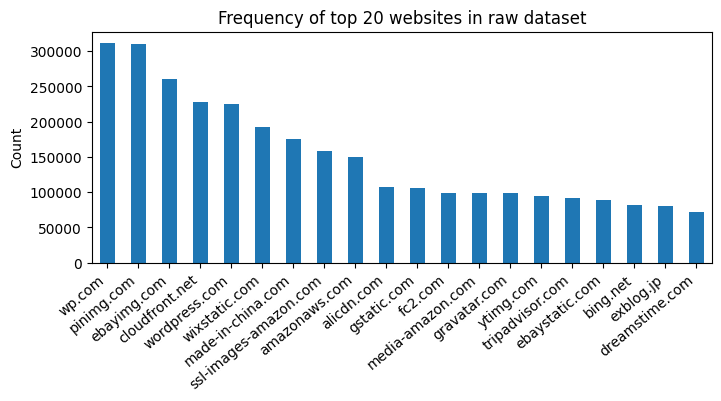

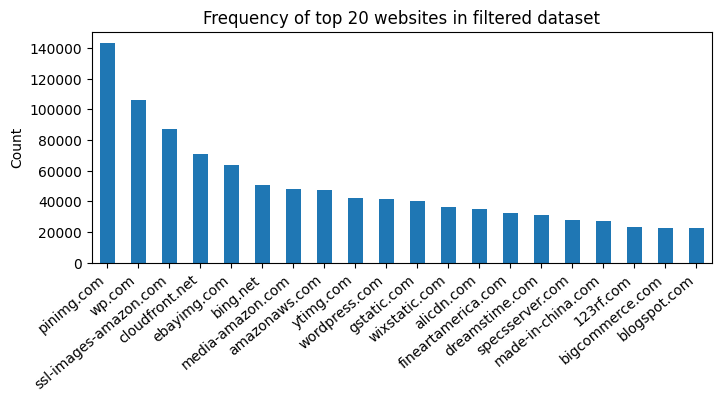

In [104]:
top_num = 20

raw_base_urls_freq = defaultdict(int)
for url in raw_base_urls:
    raw_base_urls_freq[url] += 1
sorted_raw_base_urls_freq = {k: v for k, v in sorted(
    raw_base_urls_freq.items(), key=lambda item: item[1], reverse=True
)}

results_df = pd.DataFrame({
    'url': list(sorted_raw_base_urls_freq.keys())[:top_num],
    'count': list(sorted_raw_base_urls_freq.values())[:top_num]
})
results_df.sort_values('count', ascending=False).plot(kind='bar',y='count',x='url', legend=False, figsize=(8, 3))
plt.ylabel('Count')
plt.xlabel('')
plt.xticks(rotation=40, ha='right')
plt.title('Frequency of top 20 websites in raw dataset')
plt.show()

filtered_base_urls_freq = defaultdict(int)
for url in filtered_base_urls:
    filtered_base_urls_freq[url] += 1
sorted_filtered_base_urls_freq = {k: v for k, v in sorted(
    filtered_base_urls_freq.items(), key=lambda item: item[1], reverse=True
)}
results_df = pd.DataFrame({
    'url': list(sorted_filtered_base_urls_freq.keys())[:top_num],
    'count': list(sorted_filtered_base_urls_freq.values())[:top_num]
})
results_df.sort_values('count', ascending=False).plot(kind='bar',y='count',x='url', legend=False, figsize=(8, 3))
plt.ylabel('Count')
plt.xlabel('')
plt.xticks(rotation=40, ha='right')
plt.title('Frequency of top 20 websites in filtered dataset')
plt.show()

In [22]:
for url in list(sorted_raw_base_urls_freq.keys())[:top_num]:
    print(url, sorted_raw_base_urls_freq[url])

wp.com 312029
pinimg.com 309614
ebayimg.com 260250
cloudfront.net 227561
wordpress.com 224612
wixstatic.com 193156
made-in-china.com 175502
ssl-images-amazon.com 158258
amazonaws.com 150311
alicdn.com 107829
gstatic.com 105708
fc2.com 99519
media-amazon.com 98271
gravatar.com 98258
ytimg.com 94575
tripadvisor.com 91154
ebaystatic.com 89515
bing.net 81340
exblog.jp 80919
dreamstime.com 72005


In [23]:
ratios_by_url = {}
for url in filtered_base_urls_freq:
    if raw_base_urls_freq[url] > 10000:
        ratios_by_url[url] = filtered_base_urls_freq[url] / raw_base_urls_freq[url]

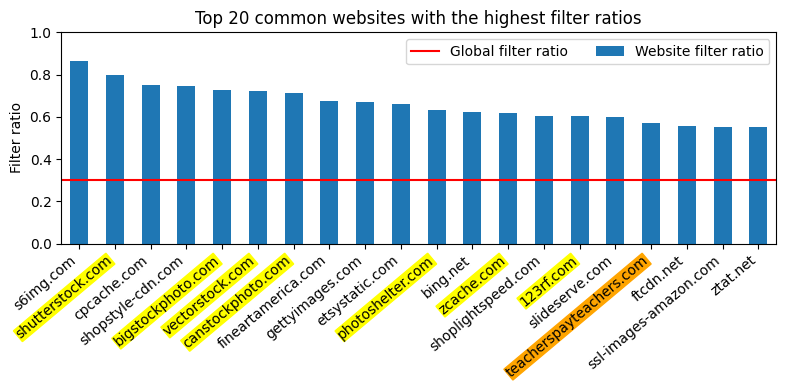

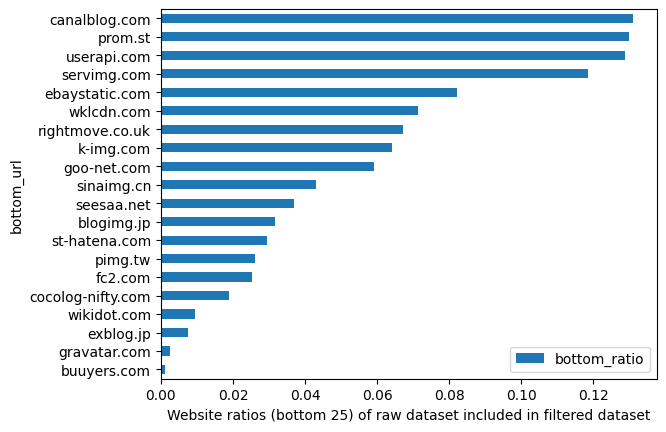

In [52]:
sorted_ratios_by_url = {k: v for k, v in sorted(
    ratios_by_url.items(), key=lambda item: item[1], reverse=True
)}
results_df = pd.DataFrame({
    'top_url': list(sorted_ratios_by_url.keys())[:top_num],
    'Website filter ratio': list(sorted_ratios_by_url.values())[:top_num],
    'bottom_url': list(sorted_ratios_by_url.keys())[-top_num:],
    'bottom_ratio': list(sorted_ratios_by_url.values())[-top_num:]
})
fig, ax = plt.subplots(figsize=(8, 4))
results_df.sort_values('Website filter ratio', ascending=False).plot(
    kind='bar',y='Website filter ratio',x='top_url', legend=True, ax=ax
)
ax.set_ylim(0, 1)
ax.set_ylabel('Filter ratio')
ax.set_xlabel('')
ax.set_xticks(np.arange(top_num), labels=results_df['top_url'], rotation=40, ha='right')
plt.title('Top 20 common websites with the highest filter ratios')

highlight_is = [1, 4, 5, 6, 10, 12, 14]
for i in highlight_is:
    label = ax.get_xticklabels()[i]
    label.set_bbox(dict(facecolor='yellow', edgecolor='yellow', pad=0))
label = ax.get_xticklabels()[16]
label.set_bbox(dict(facecolor='orange', edgecolor='orange', pad=0))

plt.axhline(y=0.3, color='r', linestyle='-', label='Global filter ratio')
plt.legend(loc='upper right', ncols=3)

fig.tight_layout()
plt.show()

results_df.sort_values('bottom_ratio').plot(kind='barh',y='bottom_ratio',x='bottom_url')
plt.xlabel('Website ratios (bottom 25) of raw dataset included in filtered dataset')
plt.show()

In [28]:
print(list(sorted_ratios_by_url.keys())[:top_num])
for url in list(sorted_ratios_by_url.keys())[:top_num]:
    print(url, sorted_ratios_by_url[url])
    
print(list(sorted_ratios_by_url.keys())[-top_num:])
for url in list(sorted_ratios_by_url.keys())[-top_num:]:
    print(url, sorted_ratios_by_url[url])

['s6img.com', 'shutterstock.com', 'cpcache.com', 'shopstyle-cdn.com', 'bigstockphoto.com', 'vectorstock.com', 'canstockphoto.com', 'fineartamerica.com', 'gettyimages.com', 'etsystatic.com', 'photoshelter.com', 'bing.net', 'zcache.com', 'shoplightspeed.com', '123rf.com', 'slideserve.com', 'teacherspayteachers.com', 'ftcdn.net', 'ssl-images-amazon.com', 'ztat.net']
s6img.com 0.8630044082739912
shutterstock.com 0.7959141877016026
cpcache.com 0.7500229463056448
shopstyle-cdn.com 0.7468101314035421
bigstockphoto.com 0.7256530825496342
vectorstock.com 0.7215663841073379
canstockphoto.com 0.7132710280373832
fineartamerica.com 0.6765744555620954
gettyimages.com 0.6692491060786651
etsystatic.com 0.6591192901741703
photoshelter.com 0.6314609889340244
bing.net 0.6233218588640276
zcache.com 0.6157172995780591
shoplightspeed.com 0.6060188542422045
123rf.com 0.6059765705992121
slideserve.com 0.5977256953713096
teacherspayteachers.com 0.5703984537615224
ftcdn.net 0.5578423542421822
ssl-images-amazon.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


112 112
0.0033129765300384897
-2.0199627808751378e-07 0.3354357566631131 -0.05755846184566167 0.5466364526516403 3.340544389882053e-07


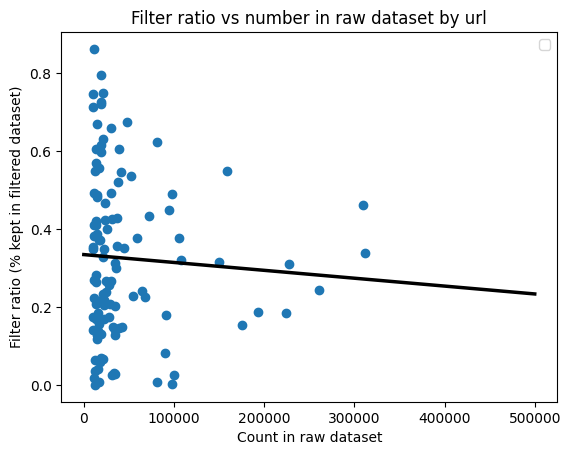

In [27]:
us = []
xs = []
ys = []

for url in ratios_by_url:
    total = raw_base_urls_freq[url]
    ratio = ratios_by_url[url]
    us.append(url)
    xs.append(total)
    ys.append(ratio)

print(len(xs), len(ys))
b, a = np.polyfit(xs, ys, deg=1)
print(np.corrcoef(xs, ys)[0,1] ** 2)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xs, ys)
print(slope, intercept, r_value, p_value, std_err)
# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 500000, num=100)
# Plot regression line
plt.scatter(xs, ys)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5)

plt.xlabel('Count in raw dataset')
plt.ylabel('Filter ratio (% kept in filtered dataset)')
plt.title('Filter ratio vs number in raw dataset by url')
plt.legend()
# plt.xscale("log")
# plt.xlim(0, 10000)
plt.show()


## News sites

In [98]:
news_csv = 'us-news-domains-v2.0.0.csv'
news_sites = pd.read_csv(news_csv)
news_sites.loc[len(news_sites.index)] = ['nyt.com', None, None]  
news_sites['base'] = news_sites['domain'].str.split('.').str[0]
news_sites

domain  ideology   type             base
0               10nbc.com       NaN    NaN            10nbc
1              10news.com    0.3315    NaN           10news
2             11alive.com    0.1956    NaN          11alive
3              12news.com    0.1167    NaN           12news
4               13abc.com    0.1424    NaN            13abc
...                   ...       ...    ...              ...
5393        zerohedge.com    0.6771    NaN        zerohedge
5394  zion-bentonnews.com       NaN    NaN  zion-bentonnews
5395            zip06.com       NaN  local            zip06
5396         zumbrota.com       NaN    NaN         zumbrota
5397              nyt.com       NaN   None              nyt

[5398 rows x 4 columns]

In [99]:
news_sites[news_sites['base'] == 'theguardian']

domain  ideology           type         base
4372  theguardian.com   -0.3893  international  theguardian

In [105]:
news_ratios_by_url = {}
news_raw_base_urls_freq = {}
news_filtered_base_urls_freq = {}

raw_base_urls_set = set(raw_base_urls)
agg_filter = 0
agg_raw = 0
for base_url in news_sites['domain'].unique():
    if base_url in raw_base_urls_set:
        raw_num = raw_base_urls_freq[base_url]
        filter_num = filtered_base_urls_freq[base_url]
        if raw_num > 200:
#             print(base_url, raw_num)
            news_ratios_by_url[base_url] = filter_num / raw_num
        
        news_raw_base_urls_freq[base_url] = raw_num
        news_filtered_base_urls_freq[base_url] = filter_num
        
        agg_raw += raw_num
        agg_filter += filter_num

print(agg_filter, agg_raw, agg_filter / agg_raw)

25521 65210 0.3913663548535501


In [56]:
news_ratios_by_url['theguardian.com']

KeyError: 'theguardian.com'

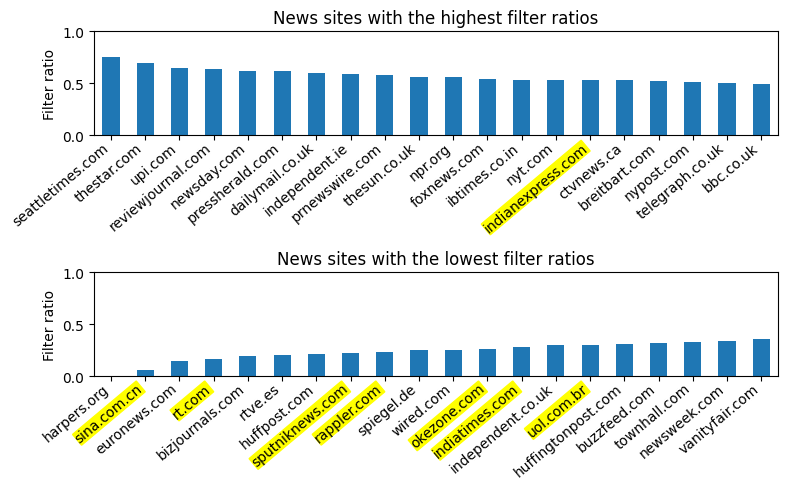

In [106]:
x = np.arange(top_num)

sorted_news_ratios_by_url = {k: v for k, v in sorted(
    news_ratios_by_url.items(), key=lambda item: item[1], reverse=True
)}
yerr = [
    get_error(
        news_filtered_base_urls_freq[base_url],
        news_raw_base_urls_freq[base_url]
    )
    for base_url in sorted_news_ratios_by_url
]

results_df = pd.DataFrame({
    'top_url': list(sorted_news_ratios_by_url.keys())[:top_num],
    'top_ratio': list(sorted_news_ratios_by_url.values())[:top_num],
    'top_yerr': yerr[:top_num],
    'bottom_url': list(sorted_news_ratios_by_url.keys())[-top_num:],
    'bottom_ratio': list(sorted_news_ratios_by_url.values())[-top_num:],
    'bottom_yerr': yerr[-top_num:],
})

fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharey=True)

results_df.sort_values('top_ratio', ascending=False).plot(
    kind='bar',y='top_ratio',x='top_url', legend=False, ax=axes[0]
)
axes[0].set_ylabel('Filter ratio')
axes[0].set_title('News sites with the highest filter ratios')
axes[0].set_xlabel('')
axes[0].set_ylim(0, 0.5)
axes[0].set_xticks(x, results_df.sort_values('top_ratio', ascending=False)['top_url'].tolist(), rotation=40, ha='right')
axes[0].tick_params(axis='x', which='major', pad=0)

nonwest_is = [14]
for i in nonwest_is:
    label = axes[0].get_xticklabels()[i]
    label.set_bbox(dict(facecolor='yellow', edgecolor='yellow', pad=0))

results_df.sort_values('bottom_ratio').plot(
    kind='bar',y='bottom_ratio',x='bottom_url', legend=False, ax=axes[1]
)
axes[1].set_ylabel('Filter ratio')
axes[1].set_title('News sites with the lowest filter ratios')
axes[1].set_xlabel('')
axes[1].set_ylim(0, 1)
axes[1].set_xticks(x, results_df.sort_values('bottom_ratio')['bottom_url'].tolist(), rotation=40, ha='right')
axes[1].tick_params(axis='x', which='major', pad=0)

nonwest_is = [1, 3, 7, 8, 11, 12, 14]
for i in nonwest_is:
    label = axes[1].get_xticklabels()[i]
    label.set_bbox(dict(facecolor='yellow', edgecolor='yellow', pad=0))

fig.tight_layout()
plt.show()

In [107]:
for n in list(sorted_news_ratios_by_url.keys())[:top_num]:
    print(n, sorted_news_ratios_by_url[n])
print('-')
for n in list(sorted_news_ratios_by_url.keys())[-top_num:]:
    print(n, sorted_news_ratios_by_url[n])

seattletimes.com 0.7548387096774194
thestar.com 0.6987620357634112
upi.com 0.6510416666666666
reviewjournal.com 0.6414565826330533
newsday.com 0.6149584487534626
pressherald.com 0.6147540983606558
dailymail.co.uk 0.5952982013253392
independent.ie 0.5860805860805861
prnewswire.com 0.5832583258325833
thesun.co.uk 0.5631641086186541
npr.org 0.5606060606060606
foxnews.com 0.5390702274975272
ibtimes.co.in 0.5357142857142857
nyt.com 0.5343396226415095
indianexpress.com 0.5305389221556887
ctvnews.ca 0.5284210526315789
breitbart.com 0.5211267605633803
nypost.com 0.5144356955380578
telegraph.co.uk 0.5059055118110236
bbc.co.uk 0.49859943977591037
-
vanityfair.com 0.3603238866396761
newsweek.com 0.3375796178343949
townhall.com 0.32432432432432434
buzzfeed.com 0.31569965870307165
huffingtonpost.com 0.31020408163265306
uol.com.br 0.3020285499624343
independent.co.uk 0.3011647254575707
indiatimes.com 0.2798507462686567
okezone.com 0.25773195876288657
wired.com 0.2529411764705882
spiegel.de 0.25
rapp

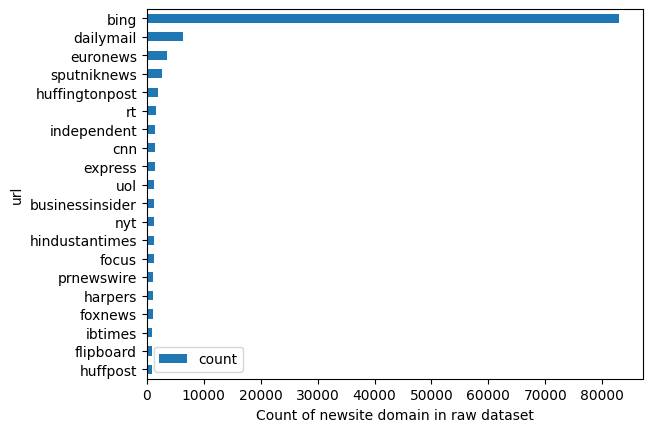

In [54]:
top_num = 20

sorted_news_raw_base_urls_freq = {k: v for k, v in sorted(
    news_raw_base_urls_freq.items(), key=lambda item: item[1], reverse=True
)}

results_df = pd.DataFrame({
    'url': list(sorted_news_raw_base_urls_freq.keys())[:top_num],
    'count': list(sorted_news_raw_base_urls_freq.values())[:top_num],
})
results_df.sort_values('count').plot(kind='barh',y='count',x='url')
plt.xlabel('Count of newsite domain in raw dataset')
plt.show()

# sorted_news_filtered_base_urls_freq = {k: v for k, v in sorted(
#     news_filtered_base_urls_freq.items(), key=lambda item: item[1], reverse=True
# )}
# results_df = pd.DataFrame({
#     'url': list(sorted_news_filtered_base_urls_freq.keys())[:top_num],
#     'count': list(sorted_news_filtered_base_urls_freq.values())[:top_num]
# })
# results_df.sort_values('count').plot(kind='barh',y='count',x='url')
# plt.xlabel('Count of newsite domain in filtered dataset')
# plt.show()

In [55]:
for n in list(sorted_news_raw_base_urls_freq.keys())[:top_num]:
    print(n, sorted_news_raw_base_urls_freq[n])

bing 82970
dailymail 6338
euronews 3489
sputniknews 2734
huffingtonpost 1960
rt 1543
independent 1515
cnn 1439
express 1432
uol 1331
businessinsider 1329
nyt 1325
hindustantimes 1228
focus 1181
prnewswire 1111
harpers 1045
foxnews 1011
ibtimes 1005
flipboard 975
huffpost 887


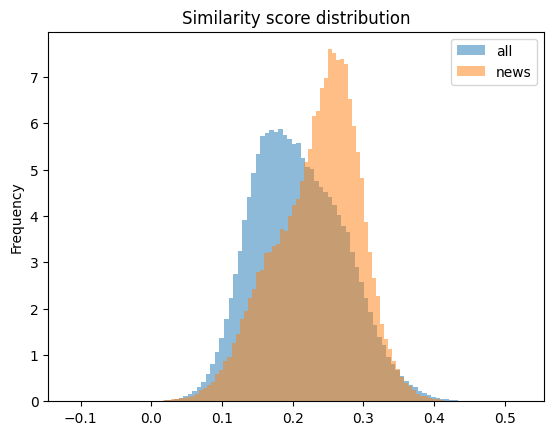

In [29]:
fig, ax = plt.subplots()
df['clip_l14_similarity_score'].plot.hist(label='all', bins=100, alpha=0.5, density=True, ax=ax)

news_base_set = set(news_sites['base'].unique())
news_df = df[df['base_url'].isin(news_base_set)]
news_df['clip_l14_similarity_score'].plot.hist(label='news', bins=100, alpha=0.5, density=True, ax=ax)

ax.set_title('Similarity score distribution')
ax.legend()
plt.show()

0.014295136995573911
0.055900517402198605 0.4003111088276107 0.11956227245905757 0.2939367439850706 0.05289927912034538


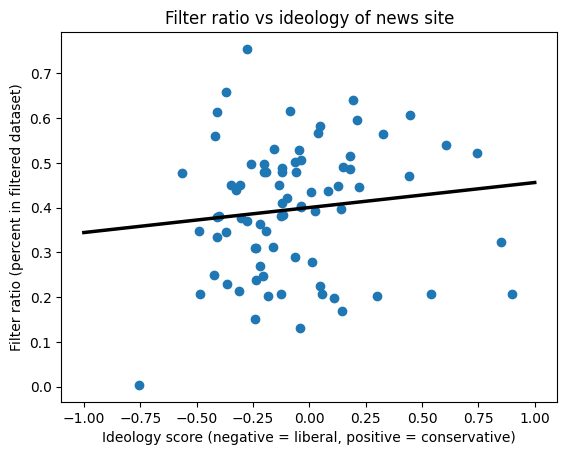

In [72]:
x = []
y = []
for _, row in news_sites.dropna(subset=['ideology']).iterrows():
    ideology = row['ideology']
    base_url = row['base']
    if base_url in news_ratios_by_url:
        x.append(ideology)
        y.append(news_ratios_by_url[base_url])

plt.xlabel('Ideology score (negative = liberal, positive = conservative)')
plt.ylabel('Filter ratio (percent in filtered dataset)') 
plt.title('Filter ratio vs ideology of news site')
plt.scatter(x, y)

b, a = np.polyfit(x, y, deg=1)
print(np.corrcoef(x, y)[0,1] ** 2)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(slope, intercept, r_value, p_value, std_err)
# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(-1, 1, num=100)

# Plot regression line
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);

In [110]:
# english
from langdetect import detect

pattern = re.compile(r'[^A-Za-z ]+')

def clean_caption(caption, as_set=False):
    # only return unique words in caption
    cleaned_caption = pattern.sub(' ', caption.lower())
    if as_set:
        return set(cleaned_caption.split(' '))
    else:
        return cleaned_caption

def is_english(uid):
    caption = raw_uid_to_text[uid]
    cleaned_caption = clean_caption(caption)
    if cleaned_caption.strip() != '':
        try:
            lang = detect(cleaned_caption)
            if lang == 'en':
                return True
        except Exception as e:
            pass
            # print(e, caption)
    return False

In [109]:
raw_base_urls_freq = defaultdict(list)
filtered_base_urls_freq = defaultdict(list)
filtered_uids_set = set(filtered_uids)

for i, url in enumerate(raw_base_urls):
    uid = raw_uids[i]
    raw_base_urls_freq[url].append(uid)
    
    is_filtered = uid in filtered_uids_set
    if is_filtered:
        filtered_base_urls_freq[url].append(uid)

In [111]:
news_ratios_by_url = {}
news_raw_base_urls_freq = {}
news_filtered_base_urls_freq = {}

raw_base_urls_set = set(raw_base_urls)
agg_filter = 0
agg_raw = 0
for base_url in news_sites['domain'].unique():
    if base_url in raw_base_urls_set:
        news_raw_uids = set(raw_base_urls_freq[base_url])
        news_filtered_uids = set(filtered_base_urls_freq[base_url])
        if True: # len(news_raw_uids) > 100:
            filter_num = 0
            raw_num = 0
            for uid in news_raw_uids:
                if is_english(uid):
                    raw_num += 1
                    if uid in news_filtered_uids:
                        filter_num += 1
            if raw_num > 0:
                print(base_url, filter_num, raw_num)
                news_ratios_by_url[base_url] = filter_num / raw_num
        
                news_raw_base_urls_freq[base_url] = raw_num
                news_filtered_base_urls_freq[base_url] = filter_num
        
                agg_raw += raw_num
                agg_filter += filter_num

print(agg_filter, agg_raw, agg_filter / agg_raw)

10news.com 3 13
11alive.com 6 10
12news.com 5 8
13wmaz.com 4 5
9news.com 15 20
abc.net.au 53 101
abc10.com 7 12
abc15.com 2 10
abqjournal.com 0 1
abs-cbn.com 59 113
adirondackexpress.com 1 1
advocate-news.com 0 2
advocate.com 9 22
adweek.com 18 45
afr.com 22 44
afro.com 4 6
al.com 16 47
alamedasun.com 0 5
albertleatribune.com 1 2
albionnewsonline.com 2 18
alextimes.com 1 1
alibi.com 8 23
aljazeera.com 21 44
allotsego.com 2 2
alternet.org 7 24
amac.us 0 1
americanbazaaronline.com 1 2
amisun.com 0 2
amny.com 2 3
andrewscountynews.com 0 1
annanews.com 2 5
ansa.it 1 3
ansonrecord.com 0 1
antena3.com 9 16
ap.org 22 62
apg-wi.com 8 13
archboldbuckeye.com 1 1
arkansasonline.com 25 92
arktimes.com 0 1
armenianweekly.com 2 15
artesianews.com 2 2
asahi.com 0 3
aspentimes.com 7 10
atlantablackstar.com 8 15
atlantadailyworld.com 3 4
attn.com 1 1
augustafreepress.com 1 2
austinchronicle.com 2 4
axios.com 42 55
azcapitoltimes.com 4 13
bainbridgereview.com 0 1
balita.com 2 6
baltimorepostexaminer.com

ksl.com 8 37
ksn.com 1 3
ksnt.com 1 2
ktla.com 10 11
ktnv.com 4 9
ktsm.com 1 3
ktvb.com 6 10
kvue.com 4 9
kxan.com 7 8
kxly.com 4 5
kystandard.com 5 5
lagunabeachindy.com 3 9
lakeorionreview.com 2 4
lamorindaweekly.com 0 1
laoferta.com 0 3
laopinion.com 1 1
laramieboomerang.com 1 3
laraza.com 2 2
laruecountyherald.com 2 4
lasentinel.net 5 5
lasvegassun.com 3 6
lasvegastribune.net 2 6
lasvegasweekly.com 1 7
latimes.com 1 1
laureloutlook.com 0 4
law.com 4 12
laweekly.com 0 35
lawfareblog.com 0 1
lawndalenews.com 3 19
lbpost.com 0 1
lccentral.com 0 1
lcnme.com 14 32
leadertelegram.com 1 2
lebanonenterprise.com 2 4
lehighvalleylive.com 8 9
lemarssentinel.com 0 1
lewistownnews.com 0 1
libn.com 5 16
licjournal.com 0 1
lifezette.com 1 1
limaohio.com 1 3
lincolnsentinel.com 1 2
livemint.com 43 109
livingstonenterprise.com 0 4
local10.com 7 15
localheadlinenews.com 0 1
longislandpress.com 10 20
loscerritosnews.net 0 4
lowellsun.com 1 3
lpleader.com 0 2
luminanews.com 2 5
machiasnews.com 0 3
mac

thefranklintimes.com 6 17
thegatewaypundit.com 10 16
thegroundtruthproject.org 1 2
thehawaiiherald.com 2 2
theheraldtimes.com 4 7
thehindu.com 6 18
thehindubusinessline.com 1 11
theintercept.com 0 4
theislandnow.com 3 6
theitem.com 0 1
themarysue.com 12 18
themorningsun.com 0 4
themountaineagle.com 1 2
thenation.com 7 14
thenews-gazette.com 0 1
thenews.com.pk 36 95
thenewsherald.com 0 2
thenewsobserver.com 0 1
theoaklandpress.com 0 4
theperspective.com 0 1
thepoliticalinsider.com 0 1
theprowersjournal.com 0 3
therealnews.com 1 2
thereporter.com 0 2
therepublic.com 1 1
thescottishsun.co.uk 21 36
thespringfieldsun.com 1 1
thestar.com 494 688
thestranger.com 0 1
thestreet.com 25 137
thesun.co.uk 451 742
thesuntimesnews.com 1 1
thetab.com 4 53
thetahoeweekly.com 0 1
thetimes.co.uk 96 194
theunion.com 7 12
thevidette.com 1 2
thevillager.com 0 1
thevillagereporter.com 0 1
thevwindependent.com 1 1
theweek.com 8 17
thewestfieldnews.com 2 2
thinkstewartville.com 1 1
time.com 68 101
times-standa

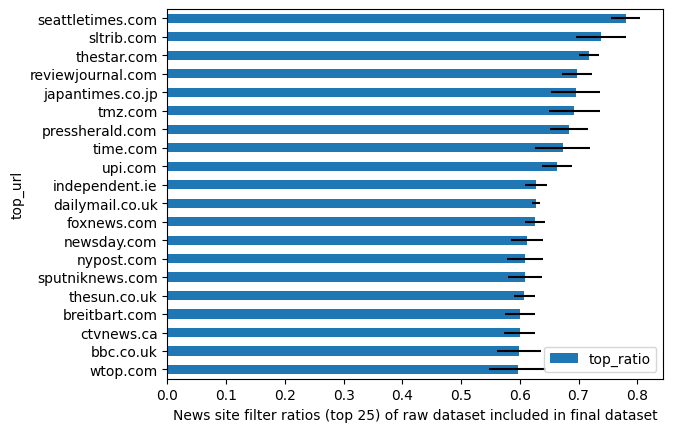

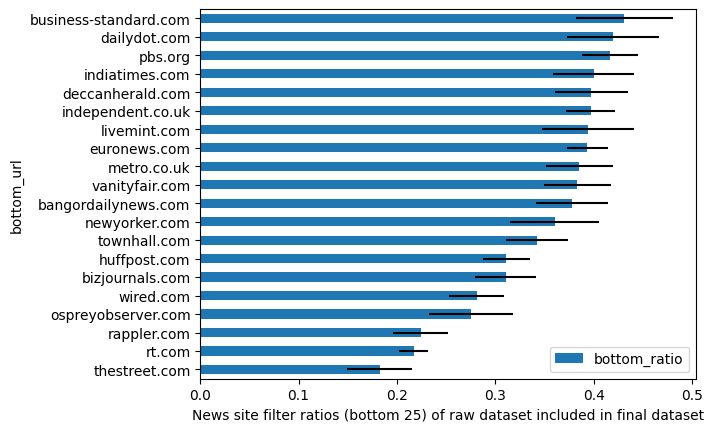

In [116]:
top_num = 20
sorted_news_ratios_by_url = {k: v for k, v in sorted(
    news_ratios_by_url.items(), key=lambda item: item[1], reverse=True
) if news_raw_base_urls_freq[k] >= 100}
yerr = [
    get_error(
        news_filtered_base_urls_freq[base_url],
        news_raw_base_urls_freq[base_url]
    )
    for base_url in sorted_news_ratios_by_url
]

results_df = pd.DataFrame({
    'top_url': list(sorted_news_ratios_by_url.keys())[:top_num],
    'top_ratio': list(sorted_news_ratios_by_url.values())[:top_num],
    'top_yerr': yerr[:top_num],
    'bottom_url': list(sorted_news_ratios_by_url.keys())[-top_num:],
    'bottom_ratio': list(sorted_news_ratios_by_url.values())[-top_num:],
    'bottom_yerr': yerr[-top_num:],
})
results_df.sort_values('top_ratio').plot(kind='barh',y='top_ratio',x='top_url',xerr='top_yerr')
plt.xlabel('News site filter ratios (top 25) of raw dataset included in final dataset')
plt.show()

results_df.sort_values('bottom_ratio').plot(kind='barh',y='bottom_ratio',x='bottom_url',xerr='bottom_yerr')
plt.xlabel('News site filter ratios (bottom 25) of raw dataset included in final dataset')
plt.show()

In [114]:
for n in list(sorted_news_ratios_by_url.keys())[:top_num]:
    print(n, ',', sorted_news_ratios_by_url[n])
print('-')
for n in list(sorted_news_ratios_by_url.keys())[-top_num:]:
    print(n, ',', sorted_news_ratios_by_url[n])

seattletimes.com , 0.7800687285223368
sltrib.com , 0.7383177570093458
thestar.com , 0.7180232558139535
reviewjournal.com , 0.6977491961414791
japantimes.co.jp , 0.6949152542372882
tmz.com , 0.6929824561403509
pressherald.com , 0.6842105263157895
time.com , 0.6732673267326733
upi.com , 0.6627906976744186
independent.ie , 0.6278735632183908
dailymail.co.uk , 0.6278625954198473
foxnews.com , 0.6262019230769231
newsday.com , 0.6123076923076923
nypost.com , 0.6091954022988506
sputniknews.com , 0.6091549295774648
thesun.co.uk , 0.6078167115902965
breitbart.com , 0.6005361930294906
ctvnews.ca , 0.6
bbc.co.uk , 0.5988023952095808
wtop.com , 0.5961538461538461
-
business-standard.com , 0.43137254901960786
dailydot.com , 0.41964285714285715
pbs.org , 0.41694915254237286
indiatimes.com , 0.4
deccanherald.com , 0.39766081871345027
independent.co.uk , 0.3968668407310705
livemint.com , 0.3944954128440367
euronews.com , 0.39361702127659576
metro.co.uk , 0.3853658536585366
vanityfair.com , 0.383495145

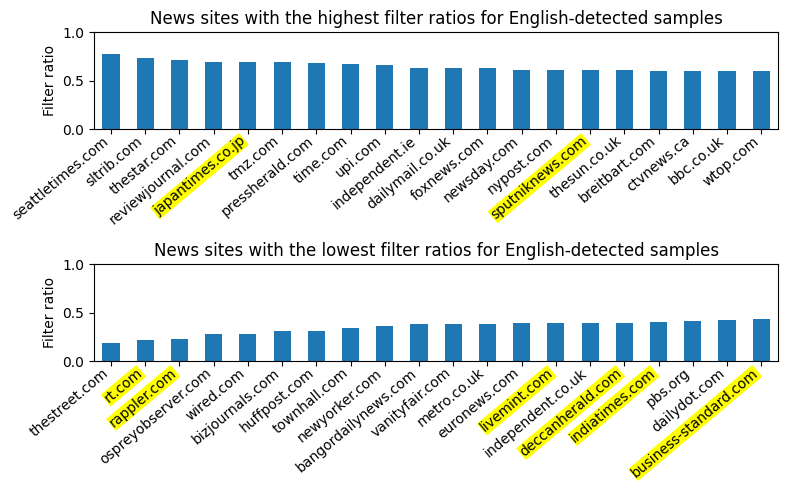

In [119]:
x = np.arange(top_num)

yerr = [
    get_error(
        news_filtered_base_urls_freq[base_url],
        news_raw_base_urls_freq[base_url]
    )
    for base_url in sorted_news_ratios_by_url
]

results_df = pd.DataFrame({
    'top_url': list(sorted_news_ratios_by_url.keys())[:top_num],
    'top_ratio': list(sorted_news_ratios_by_url.values())[:top_num],
    'top_yerr': yerr[:top_num],
    'bottom_url': list(sorted_news_ratios_by_url.keys())[-top_num:],
    'bottom_ratio': list(sorted_news_ratios_by_url.values())[-top_num:],
    'bottom_yerr': yerr[-top_num:],
})

fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharey=True)

results_df.sort_values('top_ratio', ascending=False).plot(
    kind='bar',y='top_ratio',x='top_url', legend=False, ax=axes[0]
)
axes[0].set_ylabel('Filter ratio')
axes[0].set_title('News sites with the highest filter ratios for English-detected samples')
axes[0].set_xlabel('')
axes[0].set_ylim(0, 0.5)
axes[0].set_xticks(x, results_df.sort_values('top_ratio', ascending=False)['top_url'].tolist(), rotation=40, ha='right')
axes[0].tick_params(axis='x', which='major', pad=0)

nonwest_is = [4, 14]
for i in nonwest_is:
    label = axes[0].get_xticklabels()[i]
    label.set_bbox(dict(facecolor='yellow', edgecolor='yellow', pad=0))

results_df.sort_values('bottom_ratio').plot(
    kind='bar',y='bottom_ratio',x='bottom_url', legend=False, ax=axes[1]
)
axes[1].set_ylabel('Filter ratio')
axes[1].set_title('News sites with the lowest filter ratios for English-detected samples')
axes[1].set_xlabel('')
axes[1].set_ylim(0, 1)
axes[1].set_xticks(x, results_df.sort_values('bottom_ratio')['bottom_url'].tolist(), rotation=40, ha='right')
axes[1].tick_params(axis='x', which='major', pad=0)

nonwest_is = [1, 2, 13, 15, 16, 19]
for i in nonwest_is:
    label = axes[1].get_xticklabels()[i]
    label.set_bbox(dict(facecolor='yellow', edgecolor='yellow', pad=0))

fig.tight_layout()
plt.show()

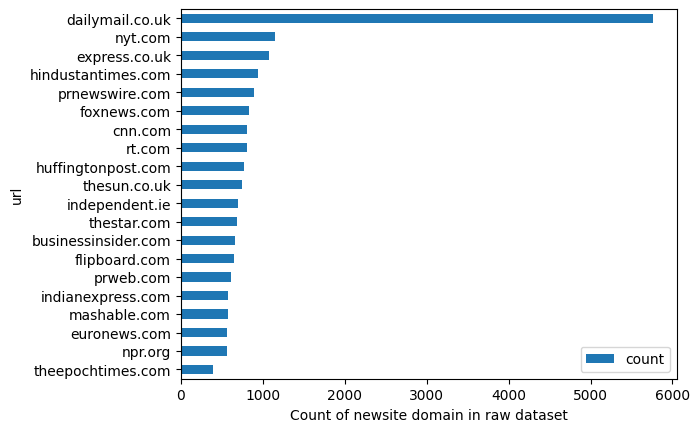

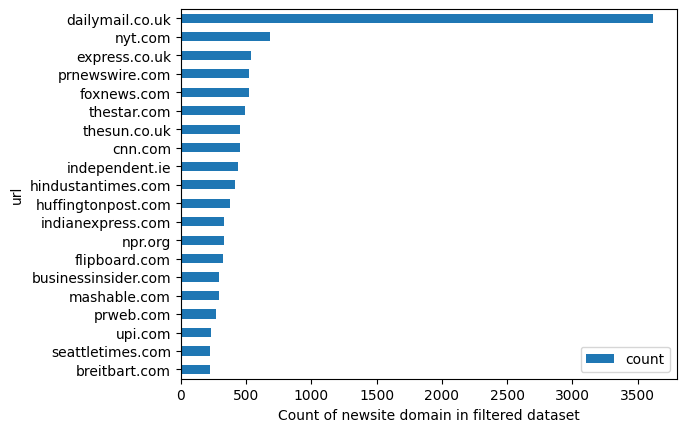

In [115]:
top_num = 20

sorted_news_raw_base_urls_freq = {k: v for k, v in sorted(
    news_raw_base_urls_freq.items(), key=lambda item: item[1], reverse=True
)}

results_df = pd.DataFrame({
    'url': list(sorted_news_raw_base_urls_freq.keys())[:top_num],
    'count': list(sorted_news_raw_base_urls_freq.values())[:top_num]
})
results_df.sort_values('count').plot(kind='barh',y='count',x='url')
plt.xlabel('Count of newsite domain in raw dataset')
plt.show()

sorted_news_filtered_base_urls_freq = {k: v for k, v in sorted(
    news_filtered_base_urls_freq.items(), key=lambda item: item[1], reverse=True
)}
results_df = pd.DataFrame({
    'url': list(sorted_news_filtered_base_urls_freq.keys())[:top_num],
    'count': list(sorted_news_filtered_base_urls_freq.values())[:top_num]
})
results_df.sort_values('count').plot(kind='barh',y='count',x='url')
plt.xlabel('Count of newsite domain in filtered dataset')
plt.show()

In [54]:
for n in list(sorted_news_raw_base_urls_freq.keys()):
    f = sorted_news_raw_base_urls_freq[n]
    if f >= 20:
        print(n, ',', f)

dailymail.co.uk , 234
euronews.com , 122
sputniknews.com , 82
rt.com , 65
huffingtonpost.com , 63
express.co.uk , 55
nyt.com , 55
cnn.com , 43
uol.com.br , 40
businessinsider.com , 38
hindustantimes.com , 38
harpers.org , 36
thesun.co.uk , 36
flipboard.com , 33
foxnews.com , 29
huffpost.com , 29
indianexpress.com , 29
mashable.com , 27
prweb.com , 26
prnewswire.com , 25
npr.org , 23
thestar.com , 23
buzzfeed.com , 21
independent.co.uk , 21


## Domains

In [89]:
def get_suffix(url):
    suffix = extract(url).suffix
    return suffix

In [90]:
raw_domains = [get_suffix(url) for url in raw_urls]
filtered_domains = [get_suffix(url) for url in filtered_urls]

In [91]:
get_suffix(raw_urls[0])

'com'

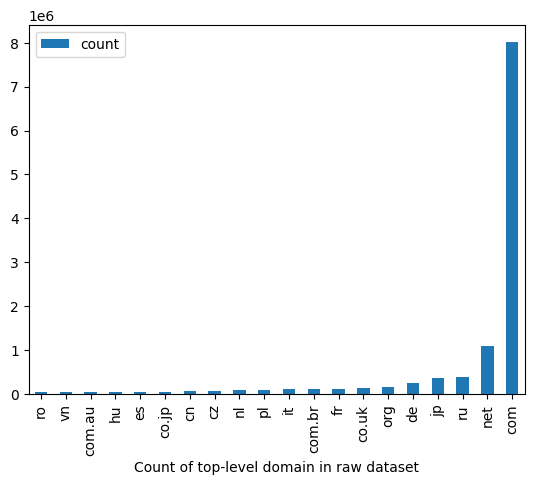

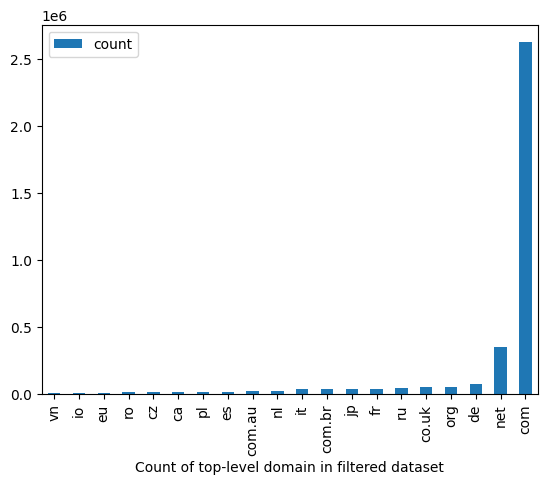

In [92]:
top_num = 20

raw_domains_freq = defaultdict(int)
for domain in raw_domains:
    raw_domains_freq[domain] += 1
sorted_raw_domains_freq = {k: v for k, v in sorted(
    raw_domains_freq.items(), key=lambda item: item[1], reverse=True
)}

results_df = pd.DataFrame({
    'domain': list(sorted_raw_domains_freq.keys())[:top_num],
    'count': list(sorted_raw_domains_freq.values())[:top_num]
})
results_df.sort_values('count').plot(kind='bar',y='count',x='domain')
plt.xlabel('Count of top-level domain in raw dataset')
plt.show()

filtered_domains_freq = defaultdict(int)
for domain in filtered_domains:
    filtered_domains_freq[domain] += 1
sorted_filtered_domains_freq = {k: v for k, v in sorted(
    filtered_domains_freq.items(), key=lambda item: item[1], reverse=True
)}
results_df = pd.DataFrame({
    'domain': list(sorted_filtered_domains_freq.keys())[:top_num],
    'count': list(sorted_filtered_domains_freq.values())[:top_num]
})
results_df.sort_values('count').plot(kind='bar',y='count',x='domain')
plt.xlabel('Count of top-level domain in filtered dataset')
plt.show()

In [93]:
for c in list(sorted_raw_domains_freq.keys())[:top_num]:
    print(c, ',', sorted_raw_domains_freq[c])

com , 8005510
net , 1097157
ru , 390358
jp , 367907
de , 260530
org , 175237
co.uk , 139268
fr , 122864
com.br , 120779
it , 115299
pl , 100554
nl , 93123
cz , 84403
cn , 77575
co.jp , 59404
es , 58248
hu , 54126
com.au , 52287
vn , 51901
ro , 51289


In [94]:
ratios_by_domain = {}
for domain in filtered_domains_freq:
    if raw_domains_freq[domain] > 10000:
        ratios_by_domain[domain] = filtered_domains_freq[domain] / raw_domains_freq[domain]

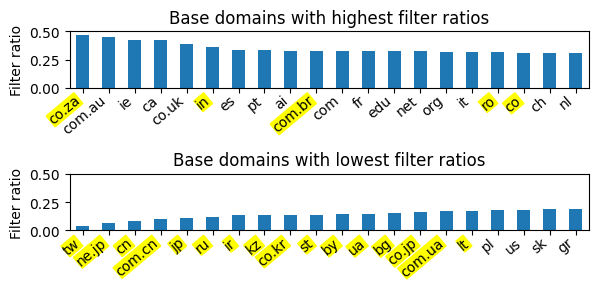

In [95]:
x = np.arange(top_num)

sorted_ratios_by_domain = {k: v for k, v in sorted(
    ratios_by_domain.items(), key=lambda item: item[1], reverse=True
)}
results_df = pd.DataFrame({
    'top_domain': list(sorted_ratios_by_domain.keys())[:top_num],
    'top_ratio': list(sorted_ratios_by_domain.values())[:top_num],
    'bottom_domain': list(sorted_ratios_by_domain.keys())[-top_num:],
    'bottom_ratio': list(sorted_ratios_by_domain.values())[-top_num:]
})
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharey=True)

results_df.sort_values('top_ratio', ascending=False).plot(
    kind='bar',y='top_ratio',x='top_domain', legend=False, ax=axes[0]
)
axes[0].set_ylabel('Filter ratio')
axes[0].set_title('Base domains with highest filter ratios')
axes[0].set_xlabel('')
axes[0].set_ylim(0, 0.5)
axes[0].set_xticks(x, results_df['top_domain'].tolist(), rotation=40, ha='right')
axes[0].tick_params(axis='x', which='major', pad=0)

nonwest_is = [0, 5, 9, 16, 17]
for i in nonwest_is:
    label = axes[0].get_xticklabels()[i]
    label.set_bbox(dict(facecolor='yellow', edgecolor='yellow', pad=0))

results_df.sort_values('bottom_ratio').plot(
    kind='bar',y='bottom_ratio',x='bottom_domain', legend=False, ax=axes[1]
)
axes[1].set_ylabel('Filter ratio')
axes[1].set_title('Base domains with lowest filter ratios')
axes[1].set_xlabel('')
axes[1].set_ylim(0, 0.5)
axes[1].set_xticks(x, results_df.sort_values('bottom_ratio')['bottom_domain'].tolist(), rotation=40, ha='right')
axes[1].tick_params(axis='x', which='major', pad=0)

nonwest_is = range(16)
for i in nonwest_is:
    label = axes[1].get_xticklabels()[i]
    label.set_bbox(dict(facecolor='yellow', edgecolor='yellow', pad=0))

fig.tight_layout()
plt.show()

In [96]:
for c in list(sorted_ratios_by_domain.keys())[:top_num]:
    print(c, sorted_ratios_by_domain[c])
for c in list(sorted_ratios_by_domain.keys())[-top_num:]:
    print(c, sorted_ratios_by_domain[c])

co.za 0.466750208855472
com.au 0.45076213972880447
ie 0.42361173409886066
ca 0.4213114368397525
co.uk 0.3859608811787345
in 0.360748855271547
es 0.332560774618871
pt 0.3325377883850438
ai 0.32943661971830984
com.br 0.32899759064075706
com 0.32748494474430734
fr 0.32714220601640837
edu 0.32268488597544087
net 0.3222419398499941
org 0.3180150310722051
it 0.3169411703483985
ro 0.31572071984246136
co 0.312249772903139
ch 0.3108279828785447
nl 0.30721733621124747
gr 0.18831023334720398
sk 0.18524952050085045
us 0.18372905027932962
pl 0.18205143504982396
lt 0.16902211078185547
com.ua 0.16822703335283792
co.jp 0.16039323951249074
bg 0.15451190875545118
ua 0.14866699580350531
by 0.14583758069996602
st 0.1400995407924767
co.kr 0.13984877393823758
kz 0.13804874176391205
ir 0.13804219009243895
ru 0.11978235363435616
jp 0.10808981617637066
com.cn 0.096986044329776
cn 0.07974218498227521
ne.jp 0.0613959808338697
tw 0.041914209407532564


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


57 57
0.0031973248985626562
3.5443615421848966e-08 0.24097488910003073 0.05654489277169651 0.6761070837435645 8.438551077406922e-08


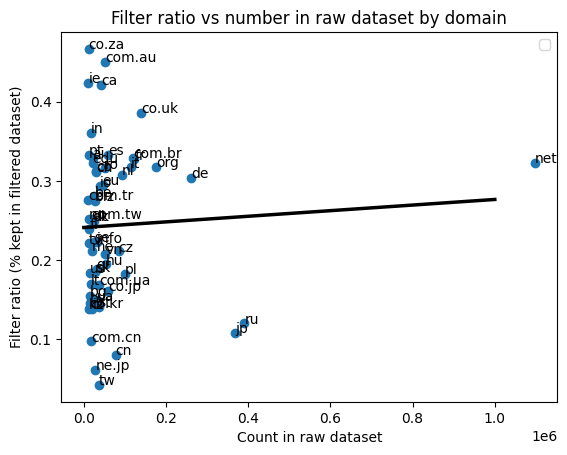

In [97]:
ds = []
xs = []
ys = []

for domain in ratios_by_domain:
    if domain == 'com':
        continue
    total = raw_domains_freq[domain]
    ratio = ratios_by_domain[domain]
    ds.append(domain)
    xs.append(total)
    ys.append(ratio)

print(len(xs), len(ys))
b, a = np.polyfit(xs, ys, deg=1)
print(np.corrcoef(xs, ys)[0,1] ** 2)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xs, ys)
print(slope, intercept, r_value, p_value, std_err)
# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1000000, num=100)
# Plot regression line
plt.scatter(xs, ys)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5)

for i in range(len(xs)):
    plt.text(xs[i], ys[i], ds[i])

plt.xlabel('Count in raw dataset')
plt.ylabel('Filter ratio (% kept in filtered dataset)')
plt.title('Filter ratio vs number in raw dataset by domain')
plt.legend()
# plt.xscale("log")
# plt.xlim(0, 10000)
plt.show()


# 1M country domain English data

In [ ]:
NUM_SAMPLE = 1000000
df_sample = df.sample(NUM_SAMPLE, random_state=0)

def get_suffix(url):
    suffix = extract(url).suffix
    return suffix

df_sample['country_domain'] = df_sample['url'].apply(get_suffix)

from langdetect import detect

pattern = re.compile(r'[^A-Za-z ]+')

def clean_caption(caption, as_set=False):
    # only return unique words in caption
    cleaned_caption = pattern.sub(' ', caption.lower())
    if as_set:
        return set(cleaned_caption.split(' '))
    else:
        return cleaned_caption

def is_english(caption):
    cleaned_caption = clean_caption(caption)
    if cleaned_caption.strip() != '':
        try:
            lang = detect(cleaned_caption)
            if lang == 'en':
                return True
        except Exception as e:
            pass
            # print(e, caption)
    return False
df_sample['is_english'] = df_sample['text'].apply(is_english)

In [71]:
df_sample

uid  \
9780367  03d81a0e6a505760b53ca302e270f3f1   
7942748  0c9f272afd52991b7f5d8df8773be670   
5228333  2ca4f648f502bd839f91fe63f5275ecf   
6091706  468207bedfbd5da43086a88496615e35   
2784619  a64a841cc8a7e9766e0262e50e2ae8df   
...                                   ...   
3954842  0f909277778c93beaf5c097ce4caf852   
8651697  9f8fab0ae3f857560fc917a416df5372   
8162843  fa6a1d8cf594820f816d9fffe17c3efb   
8646686  063bf4a15233ce7beee52ea4e0caaf37   
9704441  0be4b47fefcff85d492866b873d79d9a   

                                                       url  \
9780367  https://li3.rightinthebox.com/images/190x250/2...   
7942748  http://www.hindustantimes.com/rf/image_size_64...   
5228333  http://t0.gstatic.com/images?q=tbn:ANd9GcQWs3O...   
6091706  https://cdn.xl.thumbs.canstockphoto.com/life-p...   
2784619  https://www.specsserver.com/CACHE/FRPUTXMJAEWI...   
...                                                    ...   
3954842  http://lonestarbulldogs.com/wp-content/gallery...   
8651697  http://cigarettesrta.fun/snnyoa/DQeddmy_RPWqlU...   
8162843  https://orig14.deviantart.net/efaf/f/2013/009/...   
8646686  https://appliv-domestic.akamaized.net/v1/900x/...   
9704441  https://i.dietdoctor.com/wp-content/uploads/20...   

                                                      text  original_width  \
9780367  Bathroom Accessory Set Rectangle 3 Wall Mounte...             190   
7942748                                            Pokemon             640   
5228333  kitchen small kitchen interior design ideas sm...             249   
6091706                             Life Preserver Concept             171   
2784619  GE&reg; 5.0 DOE cu. ft. Capacity Washer with S...             500   
...                                                    ...             ...   
3954842                                      Best of Breed             100   
8651697                           علاج النحافة عند الاطفال             474   
8162843                                 Minotaur by gensym              65   
8646686                                         楽天カードマンバナー             900   
9704441                     Instead of weight-loss surgery             650   

         original_height  clip_b32_similarity_score  \
9780367              250                   0.281250   
7942748              480                   0.288330   
5228333              203                   0.321533   
6091706              239                   0.332031   
2784619              520                   0.256836   
...                  ...                        ...   
3954842               75                   0.287842   
8651697              276                   0.233887   
8162843               74                   0.267822   
8646686              506                   0.268555   
9704441              641                   0.287109   

         clip_l14_similarity_score  \
9780367                   0.255859   
7942748                   0.199219   
5228333                   0.241699   
6091706                   0.272705   
2784619                   0.278809   
...                            ...   
3954842                   0.222412   
8651697                   0.175781   
8162843                   0.264404   
8646686                   0.224731   
9704441                   0.218994   

                                               face_bboxes  \
9780367                                                 []   
7942748  [[0.0, 0.10341117531061172, 0.1547906100749969...   
5228333                                                 []   
6091706                                                 []   
2784619                                                 []   
...                                                    ...   
3954842  [[0.4710618555545807, 0.27664077281951904, 0.5...   
8651697  [[0.24295811355113983, 0.16343499720096588, 0....   
8162843  [[0.3045356273651123, 0.5207049250602722, 0.46...   
8646686  [[0.44824063777923584, 0.1413375735282898, 0.5...   
9704441  [[0.66

In [72]:
df_sample.to_parquet('df_sample_1M.parquet')

In [73]:
df_sample = pd.read_parquet('df_sample_1M.parquet')
df_sample

uid  \
9780367  03d81a0e6a505760b53ca302e270f3f1   
7942748  0c9f272afd52991b7f5d8df8773be670   
5228333  2ca4f648f502bd839f91fe63f5275ecf   
6091706  468207bedfbd5da43086a88496615e35   
2784619  a64a841cc8a7e9766e0262e50e2ae8df   
...                                   ...   
3954842  0f909277778c93beaf5c097ce4caf852   
8651697  9f8fab0ae3f857560fc917a416df5372   
8162843  fa6a1d8cf594820f816d9fffe17c3efb   
8646686  063bf4a15233ce7beee52ea4e0caaf37   
9704441  0be4b47fefcff85d492866b873d79d9a   

                                                       url  \
9780367  https://li3.rightinthebox.com/images/190x250/2...   
7942748  http://www.hindustantimes.com/rf/image_size_64...   
5228333  http://t0.gstatic.com/images?q=tbn:ANd9GcQWs3O...   
6091706  https://cdn.xl.thumbs.canstockphoto.com/life-p...   
2784619  https://www.specsserver.com/CACHE/FRPUTXMJAEWI...   
...                                                    ...   
3954842  http://lonestarbulldogs.com/wp-content/gallery...   
8651697  http://cigarettesrta.fun/snnyoa/DQeddmy_RPWqlU...   
8162843  https://orig14.deviantart.net/efaf/f/2013/009/...   
8646686  https://appliv-domestic.akamaized.net/v1/900x/...   
9704441  https://i.dietdoctor.com/wp-content/uploads/20...   

                                                      text  original_width  \
9780367  Bathroom Accessory Set Rectangle 3 Wall Mounte...             190   
7942748                                            Pokemon             640   
5228333  kitchen small kitchen interior design ideas sm...             249   
6091706                             Life Preserver Concept             171   
2784619  GE&reg; 5.0 DOE cu. ft. Capacity Washer with S...             500   
...                                                    ...             ...   
3954842                                      Best of Breed             100   
8651697                           علاج النحافة عند الاطفال             474   
8162843                                 Minotaur by gensym              65   
8646686                                         楽天カードマンバナー             900   
9704441                     Instead of weight-loss surgery             650   

         original_height  clip_b32_similarity_score  \
9780367              250                   0.281250   
7942748              480                   0.288330   
5228333              203                   0.321533   
6091706              239                   0.332031   
2784619              520                   0.256836   
...                  ...                        ...   
3954842               75                   0.287842   
8651697              276                   0.233887   
8162843               74                   0.267822   
8646686              506                   0.268555   
9704441              641                   0.287109   

         clip_l14_similarity_score  \
9780367                   0.255859   
7942748                   0.199219   
5228333                   0.241699   
6091706                   0.272705   
2784619                   0.278809   
...                            ...   
3954842                   0.222412   
8651697                   0.175781   
8162843                   0.264404   
8646686                   0.224731   
9704441                   0.218994   

                                               face_bboxes  \
9780367                                                 []   
7942748  [[0.0, 0.10341117531061172, 0.1547906100749969...   
5228333                                                 []   
6091706                                                 []   
2784619                                                 []   
...                                                    ...   
3954842  [[0.4710618555545807, 0.27664077281951904, 0.5...   
8651697  [[0.24295811355113983, 0.16343499720096588, 0....   
8162843  [[0.3045356273651123, 0.5207049250602722, 0.46...   
8646686  [[0.44824063777923584, 0.1413375735282898, 0.5...   
9704441  [[0.66

In [74]:
english_df_sample = df_sample[df_sample['is_english'] == True]
filtered_english_df_sample = english_df_sample[english_df_sample['is_kept'] == True]
raw_domains = english_df_sample['country_domain'].tolist()
filtered_domains = filtered_english_df_sample['country_domain'].tolist()

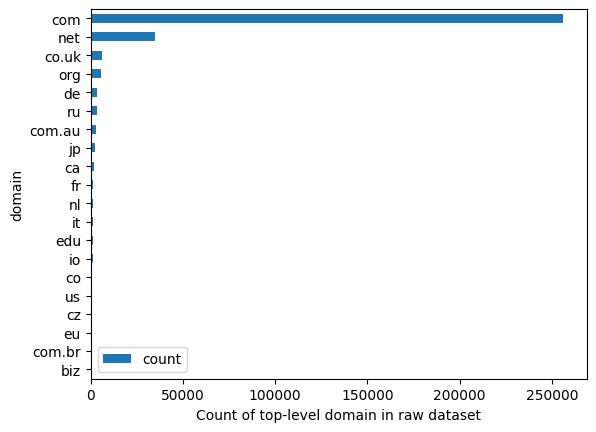

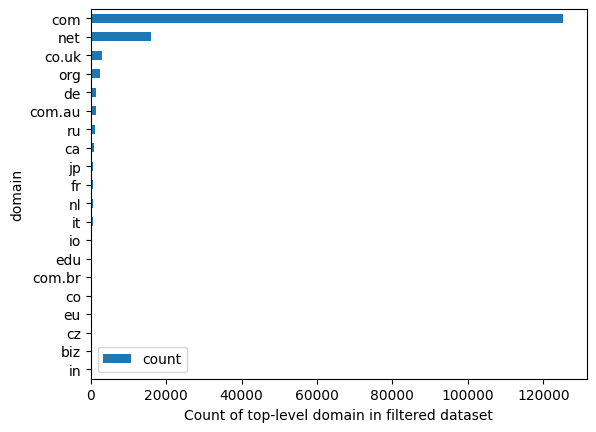

In [75]:
top_num = 20

raw_domains_freq = defaultdict(int)
for domain in raw_domains:
    raw_domains_freq[domain] += 1
sorted_raw_domains_freq = {k: v for k, v in sorted(
    raw_domains_freq.items(), key=lambda item: item[1], reverse=True
)}

results_df = pd.DataFrame({
    'domain': list(sorted_raw_domains_freq.keys())[:top_num],
    'count': list(sorted_raw_domains_freq.values())[:top_num]
})
results_df.sort_values('count').plot(kind='barh',y='count',x='domain')
plt.xlabel('Count of top-level domain in raw dataset')
plt.show()

filtered_domains_freq = defaultdict(int)
for domain in filtered_domains:
    filtered_domains_freq[domain] += 1
sorted_filtered_domains_freq = {k: v for k, v in sorted(
    filtered_domains_freq.items(), key=lambda item: item[1], reverse=True
)}
results_df = pd.DataFrame({
    'domain': list(sorted_filtered_domains_freq.keys())[:top_num],
    'count': list(sorted_filtered_domains_freq.values())[:top_num]
})
results_df.sort_values('count').plot(kind='barh',y='count',x='domain')
plt.xlabel('Count of top-level domain in filtered dataset')
plt.show()

In [76]:
for c in list(sorted_raw_domains_freq.keys())[:top_num]:
    print(c, ',', sorted_raw_domains_freq[c])

com , 255969
net , 34790
co.uk , 6296
org , 5752
de , 3493
ru , 3235
com.au , 2641
jp , 2347
ca , 1859
fr , 1402
nl , 1235
it , 1177
edu , 1037
io , 1021
co , 895
us , 895
cz , 831
eu , 831
com.br , 786
biz , 743


In [77]:
ratios_by_domain = {}
for domain in filtered_domains_freq:
    if raw_domains_freq[domain] >= 100:
        ratios_by_domain[domain] = filtered_domains_freq[domain] / raw_domains_freq[domain]
print(len(ratios_by_domain))

68


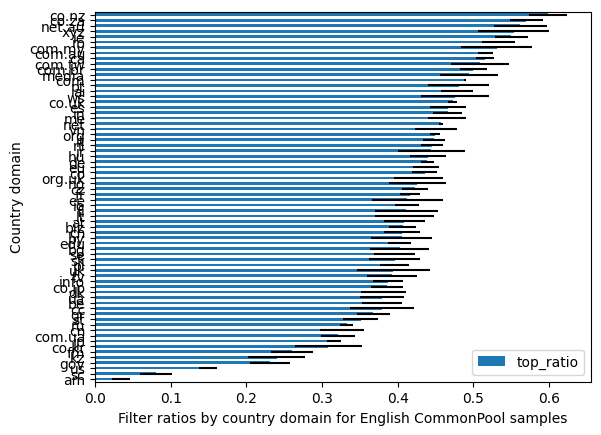

In [82]:
sorted_ratios_by_domain = {k: v for k, v in sorted(
    ratios_by_domain.items(), key=lambda item: item[1], reverse=True
)}

yerr = [
    get_error(
        filtered_domains_freq[domain],
        raw_domains_freq[domain]
    )
    for domain in sorted_ratios_by_domain
]

results_df = pd.DataFrame({
    'top_domain': list(sorted_ratios_by_domain.keys()), # [:top_num],
    'top_ratio': list(sorted_ratios_by_domain.values()), # [:top_num],
    'top_yerr': yerr,
#     'bottom_domain': list(sorted_ratios_by_domain.keys())[-top_num:],
#     'bottom_ratio': list(sorted_ratios_by_domain.values())[-top_num:]
})
results_df.sort_values('top_ratio').plot(kind='barh',y='top_ratio',x='top_domain',xerr='top_yerr')
plt.ylabel('Country domain')
plt.xlabel('Filter ratios by country domain for English CommonPool samples')
plt.show()

# results_df.sort_values('bottom_ratio').plot(kind='barh',y='bottom_ratio',x='bottom_domain')
# plt.xlabel('Domain ratios (bottom 25) of raw dataset included in filtered dataset')
# plt.show()

In [83]:
for c in list(sorted_ratios_by_domain.keys())[:top_num]:
    print(c, ',', sorted_ratios_by_domain[c])
for c in list(sorted_ratios_by_domain.keys())[-top_num:]:
    print(c, ',', sorted_ratios_by_domain[c])

co.nz , 0.5989159891598916
co.za , 0.5700389105058365
net.au , 0.5621890547263682
xyz , 0.5535714285714286
ie , 0.55
ro , 0.5333333333333333
com.my , 0.5309734513274337
com.au , 0.5157137447936387
ca , 0.5153308230231307
com.tw , 0.5086705202312138
com.br , 0.5
media , 0.49411764705882355
com , 0.4892311178306748
pt , 0.4807692307692308
ai , 0.4787985865724382
ws , 0.47580645161290325
co.uk , 0.4726810673443456
es , 0.46651785714285715
in , 0.46594427244582043
me , 0.465
tv , 0.3926940639269406
info , 0.38704318936877075
co.jp , 0.38596491228070173
dk , 0.38113207547169814
ua , 0.37992831541218636
be , 0.37910447761194027
cc , 0.3787878787878788
gr , 0.3680851063829787
st , 0.35096153846153844
ru , 0.33261205564142193
cn , 0.32677165354330706
com.ua , 0.32134831460674157
jp , 0.31614827439284193
co.kr , 0.308411214953271
fm , 0.2603305785123967
kz , 0.24031007751937986
gov , 0.23107569721115537
us , 0.14972067039106146
sc , 0.08024691358024691
am , 0.03389830508474576


In [29]:
len(english_df_sample)

354956

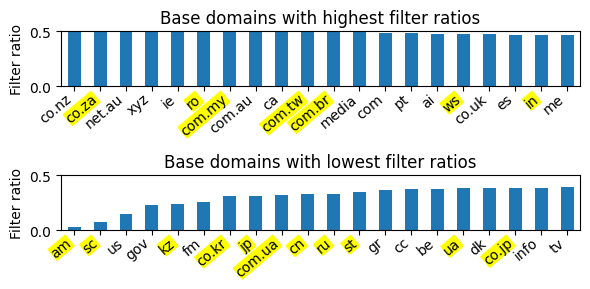

In [87]:
x = np.arange(top_num)

results_df = pd.DataFrame({
    'top_domain': list(sorted_ratios_by_domain.keys())[:top_num],
    'top_ratio': list(sorted_ratios_by_domain.values())[:top_num],
    'bottom_domain': list(sorted_ratios_by_domain.keys())[-top_num:],
    'bottom_ratio': list(sorted_ratios_by_domain.values())[-top_num:]
})
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharey=True)

results_df.sort_values('top_ratio', ascending=False).plot(
    kind='bar',y='top_ratio',x='top_domain', legend=False, ax=axes[0]
)
axes[0].set_ylabel('Filter ratio')
axes[0].set_title('Base domains with highest filter ratios')
axes[0].set_xlabel('')
axes[0].set_ylim(0, 0.5)
axes[0].set_xticks(x, results_df['top_domain'].tolist(), rotation=40, ha='right')
axes[0].tick_params(axis='x', which='major', pad=0)

nonwest_is = [1, 5, 6, 9, 10, 15, 18]
for i in nonwest_is:
    label = axes[0].get_xticklabels()[i]
    label.set_bbox(dict(facecolor='yellow', edgecolor='yellow', pad=0))

results_df.sort_values('bottom_ratio').plot(
    kind='bar',y='bottom_ratio',x='bottom_domain', legend=False, ax=axes[1]
)
axes[1].set_ylabel('Filter ratio')
axes[1].set_title('Base domains with lowest filter ratios')
axes[1].set_xlabel('')
axes[1].set_ylim(0, 0.5)
axes[1].set_xticks(x, results_df.sort_values('bottom_ratio')['bottom_domain'].tolist(), rotation=40, ha='right')
axes[1].tick_params(axis='x', which='major', pad=0)

nonwest_is = [0, 1, 4, 6, 7, 8, 9, 10, 11, 15, 17]
for i in nonwest_is:
    label = axes[1].get_xticklabels()[i]
    label.set_bbox(dict(facecolor='yellow', edgecolor='yellow', pad=0))

fig.tight_layout()
plt.show()